# import libraries

In [1]:
#--- system libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from scipy.interpolate import Rbf
import random as rand
import pdb 
import sys
#
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')
#

#--- user modules
import LammpsPostProcess as lp

# Parameters

In [2]:
path = '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/testRuns/test2nd/Run0' #--- comment if passed by argument
dumpFile = ('virialStress.xyz','junk.xyz')[0]#--- parse cords

# sxyColmn = 'c_1[1]'
# muColmn = 'c_1[7]'

sxyColmn = 'c_1[4]'
muColmn = 'c_1[22]'


In [3]:
def ReturnIndxModulus(arg):
    sdict={'xxxx':0,'xxyy':1, 'xxzz':2, 'xxxy':3, 'xxxz':4, 'xxyz':5,
           'yyxx':1,'yyyy':6, 'yyzz':7, 'yyxy':8, 'yyxz':9, 'yyyz':10,
           'zzxx':2,'zzyy':7, 'zzzz':11,'zzxy':12,'zzxz':13,'zzyz':14,
           'xyxx':3,'xyyy':8, 'xyzz':12,'xyxy':15,'xyxz':16,'xyyz':17,
           'xzxx':4,'xzyy':9, 'xzzz':13,'xzxy':16,'xzxz':18,'xzyz':19,
           'yzxx':5,'yzyy':10,'yzzz':14,'yzxy':17,'yzxz':19,'yzyz':20}
    return sdict[arg]+6+1

def ReturnIndxStress(arg):
    sdict={'xx':0,'xy':3,'xz':4,
           'yx':3,'yy':1,'yz':5,
           'zx':4,'zy':5,'zz':2}
    return sdict[arg]+1

print(ReturnIndxStress('xy')) #--- stress
print(ReturnIndxModulus('xyxy')) #--- modulus


4
22


# input stress file

In [7]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]


lmpData = lp.ReadDumpFile( '%s/%s'%(path, dumpFile ) )
lmpData.GetCords( ncount = sys.maxsize )


# stress-strain curve

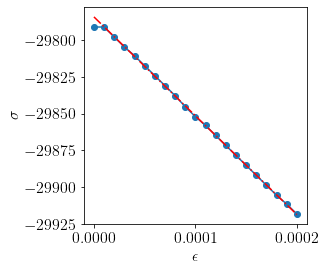

In [9]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_yscale('log')
#ax.set_ylim(1e6,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
virial = []
mu = []
strain = []
times = list(lmpData.coord_atoms_broken.keys())
times.sort()

box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

for itime in times:
    
    #--- extract atom and box properties
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))


    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    virial += [np.c_[lmpData.coord_atoms_broken[itime][sxyColmn]].astype(float).sum() / volume]
    mu += [np.c_[lmpData.coord_atoms_broken[itime][muColmn]].astype(float).sum() / volume]
    #--- strain
    if sxyColmn == 'c_1[1]':
        dx=box.CellVector[0,0]-box0.CellVector[0,0]
        l1=box.CellVector[0,0]
        strain += [dx/l1]
    #
    if sxyColmn == 'c_1[2]':
        dy=box.CellVector[1,1]-box0.CellVector[1,1]
        l2=box.CellVector[1,1]
        strain += [dy/l2]
    #
    if sxyColmn == 'c_1[4]':
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        strain += [dx/l1]

#--- plot stress
ax.plot(np.array(strain),np.array(virial),'-o')

#--- fit
coeffs = np.polyfit(np.array(strain)[1:],np.array(virial)[1:], 1)
def func(x, m, b):
    return m*x+b

#--- print fit
ax.plot(np.array(strain),func(np.array(strain), *coeffs),'-.r')

#
plt.savefig('stressStrain.png',dpi=75,bbox_inches='tight')
plt.show()

# Born Modulus

## Bulk value

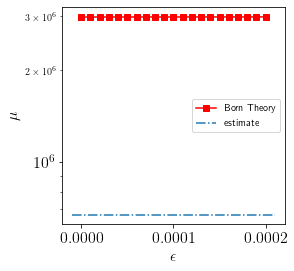

In [11]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')
#ax.set_ylim(1e5,1e6)
#ax.set_ylim(1e2,1e3)
#ax.set_ylim(1e0,1e2)
#ax.set_ylim(1e2,1e3)
#ax.set_ylim(1e5,1e7)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- plot mu
ax.plot(np.array(strain),abs(np.array(mu)),'-rs', label='Born Theory')

#--- plot stress
#ax.plot(2*np.array(strain),np.array(virial),'-o')
#ax.plot(2*np.array(strain),np.gradient(virial,2*np.array(strain)),'-o')
ax.plot(ax.axis()[:2],[ abs(coeffs[0]), abs(coeffs[0]) ],'-.', label='estimate')
#
ax.legend()
#
plt.savefig('bornModulus.png',dpi=75,bbox_inches='tight')
plt.show()

In [12]:
coeffs[0]/np.array(mu)

array([-0.22567948, -0.22567948, -0.22566849, -0.2256575 , -0.22564772,
       -0.22563673, -0.22562574, -0.22561536, -0.22560437, -0.22559338,
       -0.2255824 , -0.22557202, -0.22556165, -0.22555066, -0.22554029,
       -0.22552931, -0.22551833, -0.22550736, -0.22549698, -0.22548601,
       -0.22547564])

In [13]:
df1=pd.read_csv('%s/sfile.txt'%path,sep='\t',skiprows=2,nrows=1,index_col=False)
df2=pd.read_csv('%s/sfile.txt'%path,sep='\t',skiprows=4,index_col=False)
df1[['dsgdrm[0]', 'dsgdrm[1]', 'dsgdrm[2]', 'dsg_dr', 'dsg_ds', 'dsg_drik',
       'dsg_drjk']]

,dsgdrm[0],dsgdrm[1],dsgdrm[2],dsg_dr,dsg_ds,dsg_drik,dsg_drjk
0,243389.015735,202272.865253,-0.0,208764.843896,-38902.791826,153713.252255,160212.587313


In [14]:
dif=df2-df1
dif[['#rik', 'rjk', 'rij' ,'sij','delij[0]','delij[1]','delij[2]']]

,#rik,rjk,rij,sij,delij[0],delij[1],delij[2]
0,2.214357e-09,1.000000e-08,0.0,5.824555e-08,0.0,0.0,0.0


In [15]:
np.sum(np.c_[df1[['dsgdrm[0]', 'dsgdrm[1]', 'dsgdrm[2]', 'dsg_dr', 'dsg_ds', 'dsg_drik',
       'dsg_drjk']]] * np.c_[dif[['delij[0]', 'delij[1]', 'delij[2]','rij','sij','#rik','rjk']]])

-0.0003234127186811002

In [17]:
-2.379088844942132e+04-(-2.379088812600883e+04)

-0.0003234124887967482

### functions

In [1105]:
def GetScreen(ri,rj,rk): #what is rc
    dr = 0.5
    drinv = 1/dr
    rc=1.0
    sij = 1.0;
    
    delij = rj-ri
    rij = np.sum(delij * delij)**0.5  

    rnorm = (rc-rij)/dr
#    print 'rnorm=',rnorm
    fc,dfc, ddfc = dfcut(rnorm );
    fcij = fc;
    dfcij = dfc * drinv; 
    ddfcij = ddfc * drinv * drinv; 

    arg1_d = 0.0
    dscrfcn = 0.0
    ddscrfcn=0.0
    for k in xrange(1):
        delik = rk-ri
        deljk = rk-rj 
        rik = np.sum(delik * delik)**0.5   #np.linspace(0.5,1,4)[k]#np.random.random();
        rjk = np.sum(deljk * deljk)**0.5   #np.linspace(1,0.5,4)[k] #np.random.random()
        rij2 = rij*rij
        rij3 = rij2*rij
        rik2 = rik*rik
        rjk2 = rjk*rjk
        xik = rik2 / rij2
        dxik=-2*rik2 /rij3

        xjk = rjk2 / rij2        
        dxjk = -2*rjk2 / rij3

        a = 1 - (xik - xjk) * (xik - xjk);
        da = -2*(xik - xjk) * (dxik - dxjk)
        
#        print a, xik, xjk
#        pdb.set_trace()
        
        assert a>0.0,'a=%s'%a;
        cikj = (2.0 * (xik + xjk) + a - 2.0) / a; #//--- Eq. (4.11d)
        dcikj = (2.0 * (dxik + dxjk) + da ) / a - da*(2.0 * (xik + xjk) + a - 2.0)/a/a
        assert cikj < Cmax, 'cikj=%s, Cmax=%s'%(cikj,Cmax)
        assert cikj > Cmin, 'cikj=%s, Cmin=%s'%(cikj,Cmin)

        delc = Cmax - Cmin;
        cikj = (cikj - Cmin) / delc; #//--- func. arg. in Eq.(4.11c)
        dcikj /= delc
        sikj = fcut(cikj); #//--- Eq.(4.11c)        
        sij *= sikj;
    #    print sij, sikj
#         #kam
#         a=rij*rij * rik * rjk
#         da=2*rij * rik * rjk
#         dda=2.0 * rik * rjk
#         sij = a

        sikj,dfikj, ddfikj = dfcut(cikj );# //--- dfikj is (4.20b), sikj is (4.11c)
        dsikj=dfikj*dcikj
        coef1 = dfikj / (delc * sikj);
        dcoef1=(ddfikj*dcikj/sikj-dsikj*dfikj/sikj/sikj)/delc
        dCikj = dCfunc(rij2, rik2, rjk2);
        ddCikj = ddCfunc(rij, rij2, rik2, rjk2);
        dscrfcn = dscrfcn + coef1 * dCikj; #//--- (4.21)/rij: sum over k  1/r^2
        
        # dscrfcn = sij*{sum(coef1 * dCikj) * fcij - dfcij / rij}
        # ddscrfcn = dsij * dscrfcn / sij + 
#                     sij * { dsum(coef1 * dCikj) * fcij + sum(coef1 * dCikj) * dfcij - ddfcij / rij + dfcij / rij2 }
        ddscrfcn += dcoef1*dCikj+coef1 * ddCikj


            
#    print sij
    sfcij = sij * fcij; #//--- 4.11a
        
    coef1 = sfcij;
    coef2 = sij * dfcij / rij; #//--- scaled by rij
    arg1 = dscrfcn * rij 
    
    dsij = sij * arg1; #?????
#    ddsij = dsij * arg1 + sij * arg1_d;
    arg2 = dscrfcn
    dscrfcn = dscrfcn * coef1 - coef2; #//--- (4.22a)/rij: units of s/r^2

    ddscrfcn = dsij*dscrfcn/sij+\
                sij*(ddscrfcn * fcij + arg2 * dfcij - ddfcij / rij + dfcij / rij2 )
    ddscrfcn = dscrfcn+rij*ddscrfcn
        
    scrfcn = sij;
    fcpair = fcij;
    
#     #kam
#     dscrfcn = da/rij;
#     ddscrfcn = dda
#     scrfcn = sij/fcij;

    return scrfcn, dscrfcn, ddscrfcn, fcpair #, ddscrfcndrik, ddscrfcndrjk


def iszero(x):
    return x == 0.0
def isone(x):
    return x == 1.0

def GetDeriv( ri,  rj,  rk, sij,
                         alpha,  beta,   r3, ds,  dds,  recip,
                         dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
                         dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn, RETURN=None):

#    pdb.set_trace()
#     nv2=0
#     for m in xrange(alpha+1):
#         for n in xrange(m,gamma+1):
#             nv2+=1;



    ddUdrijmds_tmp=np.zeros(3);
    assert not iszero(ds)
    if (iszero(ds)):
        dUdsij = 0.0;
        ddUddsij = 0.0;
        for m in xrange(3):
            ddUdrijmds_tmp[m] = ddUdrijmds[m];
            ddUdrijmds[m] = 0.0;

        ddUdrijds = 0.0;


    dsg_alpha_beta_drm = np.zeros(3);
    recip2 = recip * recip;
    dsg_alpha_beta_dr = ((-recip2*(dUdsij*ds)+recip*(dUdsij*dds))*delij[alpha])*delij[beta];
    dsg_alpha_beta_ds = (recip*(ddUddsij*ds)*delij[alpha])*delij[beta];
    for gamma in xrange(3):
        dsg_alpha_beta_drm[gamma] = (recip*((dUdsij*ds)*(1 if alpha == gamma else 0)))*delij[beta];
        
    assert not iszero(sij) and not isone(sij);
    deljk=np.zeros(3)
    delki=np.zeros(3);
    rij2 = 1.0/recip2;
    if 1:
        k=2
        dsij1 = 0.0;
        dsij2 = 0.0;
        if 1:
            delc = Cmax - Cmin;
            dxjk = deljk[0]=rk[0] - rj[0];
            dyjk = deljk[1]=rk[1] - rj[1];
            dzjk = deljk[2]=rk[2] - rj[2];
            rjk2 = dxjk * dxjk + dyjk * dyjk + dzjk * dzjk;
            rjk = np.sqrt( rjk2 );
            if 1:#rjk2 <= rbound:
                dxik = delki[0]=rk[0] - ri[0];
                dyik = delki[1]=rk[1] - ri[1];
                dzik = delki[2]=rk[2] - ri[2];
                rik2 = dxik * dxik + dyik * dyik + dzik * dzik;
                rik = np.sqrt( rik2 );
            if 1:#rik2 <= rbound:
                xik = rik2 / rij2;
                xjk = rjk2 / rij2;
                dxik=-2*rik2 /rij2/rij
                dxjk = -2*rjk2 / rij2/rij
                a = 1 - (xik - xjk) * (xik - xjk);
                da = -2*(xik - xjk) * (dxik - dxjk)
                
                assert not iszero(a)
            #if not iszero(a):
                cikj = (2.0 * (xik + xjk) + a - 2.0) / a;
                dcikj = (2.0 * (dxik + dxjk) + da) / a +(2.0 * (xik + xjk) + a - 2.0) *(-da)/ a / a

                assert cikj >= Cmin and cikj <= Cmax;
#                if cikj >= Cmin and cikj <= Cmax :
                cikj = (cikj - Cmin) / delc;
                dcikj /= delc
                sikj,dfc, ddfc = dfcut(cikj);
                dCikj1, dCikj2=dCfunc2(rij2, rik2, rjk2);
                ddCikj1, ddCikj2=ddCfunc2(rij2, rik2, rjk2); #--- check these: over!
                a = sij / delc * dfc / sikj; # sij = s^\bar_{ij}*fc
                dsij=ds 
                dsikj = dfc * dcikj
                da = (dsij*dfc/sikj+sij*ddfc*dcikj/sikj-dsikj*sij*dfc/sikj/sikj)/delc
                dsij1 = a * dCikj1; #//--- 4.22b/rik: units of s/r^2
                dsij2 = a * dCikj2; #//--- 4.22c/rjk
    

                ddsij1drij = da * dCikj1+a * ddCikj1; #//--- units of s/r^3
                ddsij2drij = da * dCikj2+a * ddCikj2; #//--- units of s/r^3
            
                ddsij1drij *= rik
                ddsij2drij *= rjk

#                 #kam
#                 ddsij1drij = 2*rij*rjk
#                 ddsij2drij = 2*rij*rik

                
                dsg_alpha_beta_drjk = recip * dUdsij * ddsij2drij * delij[alpha] * delij[beta];
                dsg_alpha_beta_drik = recip * dUdsij * ddsij1drij * delij[alpha] * delij[beta];

                
#          //     Tabulate per-atom virial as symmetrized stress tensor
        assert not iszero(dsij1) or not iszero(dsij2)
    
    if RETURN:
        return dsij1*rik, dsij2*rjk, ddsij1drij, ddsij2drij
#        return a, dsij2, da, ddsij2drij
#        pdb.set_trace()
#        return dCikj1, dCikj2, ddCikj1, ddCikj2
    else:
        return dsg_alpha_beta_dr, dsg_alpha_beta_ds, dsg_alpha_beta_drm, ddsij1drij, ddsij2drij
    

def GetModulus( ri,  rj,  rk, sij,
                         alpha,  beta,  gamma,  lambdaa,   r3, ds,  dds,  recip,
                         dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
                         dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn):
    nv2=0
    for m in xrange(alpha+1):
        for n in xrange(m,gamma+1):
            nv2+=1;



    ddUdrijmds_tmp=np.zeros(3);
    assert not iszero(ds)
    if (iszero(ds)):
        dUdsij = 0.0;
        ddUddsij = 0.0;
        for m in xrange(3):
            ddUdrijmds_tmp[m] = ddUdrijmds[m];
            ddUdrijmds[m] = 0.0;

        ddUdrijds = 0.0;


    dsg_alpha_beta_drm = np.zeros(3);
    recip2 = recip * recip;
    dsg_alpha_beta_dr = ((-recip2*(dUdsij*ds)+recip*(dUdsij*dds))*delij[alpha])*delij[beta];
    dsg_alpha_beta_ds = (recip*(ddUddsij*ds)*delij[alpha])*delij[beta];
    dsg_alpha_beta_drm[gamma] = (recip*((dUdsij*ds)*(1 if alpha == gamma else 0)))*delij[beta];

    mod2bdy = (recip*(dsg_alpha_beta_dr+dsg_alpha_beta_ds*ds)*delij[gamma]+\
               dsg_alpha_beta_drm[gamma])*delij[lambdaa];
#    print 'mod2bdy=',mod2bdy
    mod3bdy = 0.0;
  
    for m in xrange(3):
        ddUdrijmds[m] = ddUdrijmds_tmp[m];
  
   

        #     Now compute forces on other atoms k due to change in sij     stiffness ?
    assert not iszero(sij) and not isone(sij);
    deljk=np.zeros(3)
    delki=np.zeros(3);
    rij2 = 1.0/recip2;
    if 1:
        k=2
        dsij1 = 0.0;
        dsij2 = 0.0;
        if 1:
            delc = Cmax - Cmin;
            dxjk = deljk[0]=rk[0] - rj[0];
            dyjk = deljk[1]=rk[1] - rj[1];
            dzjk = deljk[2]=rk[2] - rj[2];
            rjk2 = dxjk * dxjk + dyjk * dyjk + dzjk * dzjk;
            rjk = np.sqrt( rjk2 );
            if 1:#rjk2 <= rbound:
                dxik = delki[0]=rk[0] - ri[0];
                dyik = delki[1]=rk[1] - ri[1];
                dzik = delki[2]=rk[2] - ri[2];
                rik2 = dxik * dxik + dyik * dyik + dzik * dzik;
                rik = np.sqrt( rik2 );
            if 1:#rik2 <= rbound:
                xik = rik2 / rij2;
                xjk = rjk2 / rij2;
                dxik=-2*rik2 /rij2/rij
                dxjk = -2*rjk2 / rij2/rij
                a = 1 - (xik - xjk) * (xik - xjk);
                da = -2*(xik - xjk) * (dxik - dxjk)
                
                assert not iszero(a)
            #if not iszero(a):
                cikj = (2.0 * (xik + xjk) + a - 2.0) / a;
                dcikj = (2.0 * (dxik + dxjk) + da) / a +(2.0 * (xik + xjk) + a - 2.0) *(-da)/ a / a

                assert cikj >= Cmin and cikj <= Cmax;
#                if cikj >= Cmin and cikj <= Cmax :
                cikj = (cikj - Cmin) / delc;
                dcikj /= delc
                sikj,dfc, ddfc = dfcut(cikj);
                dCikj1, dCikj2=dCfunc2(rij2, rik2, rjk2);
                ddCikj1, ddCikj2=ddCfunc2(rij2, rik2, rjk2); #--- check these: over!
                a = sij / delc * dfc / sikj; # sij = s^\bar_{ij}*fc
                dsij=ds 
                dsikj = dfc * dcikj
                da = (dsij*dfc/sikj+sij*ddfc*dcikj/sikj-dsikj*sij*dfc/sikj/sikj)/delc
                dsij1 = a * dCikj1; #//--- 4.22b/rik: units of s/r^2
                dsij2 = a * dCikj2; #//--- 4.22c/rjk
    
                ddsij1drij = da * dCikj1+a * ddCikj1; #//--- units of s/r^3
                ddsij2drij = da * dCikj2+a * ddCikj2; #//--- units of s/r^3
            
                ddsij1drij *= rik
                ddsij2drij *= rjk

#                 #kam
#                 ddsij1drij = 2*rij*rjk
#                 ddsij2drij = 2*rij*rik

                dsg_alpha_beta_drjk = recip * dUdsij * ddsij2drij * delij[alpha] * delij[beta];
                dsg_alpha_beta_drik = recip * dUdsij * ddsij1drij * delij[alpha] * delij[beta];

                
#          //     Tabulate per-atom virial as symmetrized stress tensor
        assert not iszero(dsij1) or not iszero(dsij2)
#        if not iszero(dsij1) or not iszero(dsij2):
        mod3bdy += (dsg_alpha_beta_drjk/rjk + dsg_alpha_beta_ds * dsij2) * deljk[gamma] * deljk[lambdaa]+\
                   (dsg_alpha_beta_drik/rik + dsg_alpha_beta_ds * dsij1) * delki[gamma] * delki[lambdaa]
    
#     dsg_alpha_beta_ds * (dsij2 * deljk[gamma] * deljk[lambdaa]+\
#                                           dsij1 * delki[gamma] * delki[lambdaa]);

#    print 'mod3bdy=',mod3bdy


    return mod2bdy + mod3bdy;
     
    
def dCfunc2(rij2, rik2, rjk2):

#    pdb.set_trace()
    rij4 = rij2 * rij2;
    rik4 = rik2 * rik2;
    rjk4 = rjk2 * rjk2;
    a = rik2 - rjk2;
    denom = rij4 - a * a;
    denom = denom * denom;
    dCikj1 = 4 * rij2 * (rij4 + rik4 + 2 * rik2 * rjk2 - 3 * rjk4 - 2 * rij2 * a) / denom; #//---(4.17b)/rik
    dCikj2 = 4 * rij2 * (rij4 - 3 * rik4 + 2 * rik2 * rjk2 + rjk4 + 2 * rij2 * a) / denom; #//---(4.17c)/rjk
    return dCikj1, dCikj2

def ddCfunc2(rij2, rik2, rjk2):
    rij=np.sqrt(rij2)
    drij2 = 2*rij
    rij4 = rij2 * rij2;
    drij4 = 4*rij * rij2;
    rik4 = rik2 * rik2;
    drik4 = 0.0
    rjk4 = rjk2 * rjk2;
    drjk4 = 0.0
    a = rik2 - rjk2;
    da = 0
    denom = rij4 - a * a;
    denom = denom * denom;
    ddenom = 2*(rij4 - a * a)*(drij4 - 2*a * da)
    drik2=0.0
    drjk2=0.0
    
#     dCikj1 = 4 * rij2 * (rij4 + rik4 + 2 * rik2 * rjk2 - 3 * rjk4 - 2 * rij2 * a) / denom; #//---(4.17b)/rik
#     dCikj2 = 4 * rij2 * (rij4 - 3 * rik4 + 2 * rik2 * rjk2 + rjk4 + 2 * rij2 * a) / denom; #//---(4.17c)/rjk

    ddCikj1 = 4 * drij2 * (rij4 + rik4 + 2 * rik2 * rjk2 - 3 * rjk4 - 2 * rij2 * a) / denom+\
              4 * rij2 * (drij4 + drik4 + 2 * drik2 * rjk2 + 2 * rik2 * drjk2 - 3 * drjk4 - 2 * drij2 * a- 2 * rij2 * da) / denom+\
              4 * rij2 * (rij4 + rik4 + 2 * rik2 * rjk2 - 3 * rjk4 - 2 * rij2 * a)* (-ddenom) / denom / denom;
    
    ddCikj2 = 4 * drij2 * (rij4 - 3 * rik4 + 2 * rik2 * rjk2 + rjk4 + 2 * rij2 * a) / denom +\
    4 * rij2 * (drij4 - 3 * drik4 + 2 * drik2 * rjk2+ 2 * rik2 * drjk2 + drjk4 + 2 * drij2 * a+ 2 * rij2 * da) / denom+\
    4 * rij2 * (rij4 - 3 * rik4 + 2 * rik2 * rjk2 + rjk4 + 2 * rij2 * a) * (-ddenom) / denom / denom;
    
    
    return ddCikj1, ddCikj2
  
    
def dCfunc(rij2, rik2, rjk2):

    rij4 = rij2 * rij2;
    a = rik2 - rjk2;
    b = rik2 + rjk2;
    asq = a*a;
    denom = rij4 - asq;
    denom = denom * denom;
    return -4 * (-2 * rij2 * asq + rij4 * b + asq * b) / denom


def ddCfunc(rij,  rij2,  rik2, rjk2):

    rij4 = rij2 * rij2;
    rij3 = rij2 * rij;
    drij4=4*rij3
    a = rik2 - rjk2;
    da = 0.0
    b = rik2 + rjk2;
    db=0.0
    asq = a*a;
    dasq=2*a*da
    denom = rij4 - asq;
    denom = denom * denom;
    ddenom = 2*(rij4-asq)*(drij4-dasq);

#     dcikj = dCfunc(rij2, rik2, rjk2);
#     ddcikj = -4 * (-2 * 2 * rij * asq + 4*rij3 * b ) - dcikj * ddenom;
#     ddcikj /= denom;

#     return ddcikj * rij+dcikj;    
    drij2 = 2*rij
    dasq = 2*a*da
    drij4 = 4*rij3
    return -4 * (-2 * (drij2 * asq+rij2 * dasq) + (drij4 * b+rij4 * db) + (dasq * b+asq * db))/denom+\
            4 * ddenom * (-2 * rij2 * asq + rij4 * b + asq * b) / denom / denom

def fcut(xi):
    if xi >= 1.0:
        return 1.0;
    elif xi <= 0.0:
        return 0.0;
    else:
        a = 1.0 - xi;
        a *= a; a *= a;
        a = 1.0 - a;
    return a * a;

### modulus

In [1108]:
Ri=np.random.random(3)
Ri[0]=0.25;Ri[2]=0.0
rj=np.array([0,0,0]) #np.random.random(3)
rk=np.array([0.5,0,0])#random.random(3)
scaleij = 1.0
ddUdrijmds = np.zeros(3)
dUdrijm = np.zeros(3)
ddUdrmdrn = np.zeros(6)
f = np.zeros(2*3).reshape((2,3))
ddUdrdrijm=np.zeros(3)
vatom = np.zeros(2*(6+21)).reshape((2,6+21))
fi = np.zeros(3)
v=np.zeros(6)
vm=np.zeros(21)

virial = []
mu = []
strain = []

Rij=[]
dscrfcnn=[]
ddscrfcnn=[]
SIJ=[]
for eps in np.linspace(0,.00001,2):
    
    f[0][:]=0.0
    f[1][:]=0.0
    vatom[0][:]=0.0
    vatom[1][:]=0.0


    print eps
#     F=np.array([[1.0+eps,0,0],
#           [0,1,0],
#           [0,0,1]])
    F=np.array([[1.0,eps,0],
          [0,1,0],
          [0,0,1]])
    i=0
    j=1
    ri=np.matmul(F,Ri) #+np.array([dx,0.0,0.0])
    delij = rj-ri
    rij = np.sum(delij * delij)**0.5  
    recip = 1/rij
    
    scrfcn, dscrfcn, ddscrfcn, fcpair = GetScreen(ri,rj,rk)
    
    Rij+=[rij]
    dscrfcnn+=[dscrfcn]
    ddscrfcnn+=[ddscrfcn]
    
#    print scrfcn, dscrfcn, ddscrfcn, fcpair
    
    r3 = rij*rij*rij;
    sij = scrfcn * fcpair;
#    sij = rij*rij;
    ds = dscrfcn * rij;
#    ds = 2*rij;dscrfcn=ds/rij;
    dds = ddscrfcn;
#    dds = 2.0;
#    print 'sij=',sij
    SIJ+=[sij]
    
    dUdrij = 0.0;
    ddUddrij = 0.0;
    dUdsij = 0.0;
    ddUddsij = 0.0;
    for m in xrange(3): ddUdrijmds[m] = 0.0;
    ddUdrijds = 0.0;
    assert not iszero(dscrfcn)
    if 1: #not iszero(dscrfcn):
        dUdsij = 1.0;
        ddUddsij = 0.0;
        for m in xrange(3): ddUdrijmds[m] = 0.0;
        ddUdrijds = 0.0;
        nv2 = 0;
        for m in xrange(3):
            dUdrijm[m] = 0.0;
            ddUdrdrijm[m] = 0.0
            for n in xrange(m,3):
                ddUdrmdrn[nv2] =  0.0;
                nv2 +=1;
            
          
         
    if not isone(scaleij):
        dUdrij *= scaleij;
        dUdsij *= scaleij;
        dUdrijm[0] *= scaleij;
        dUdrijm[1] *= scaleij;
        dUdrijm[2] *= scaleij;
        
        ddUddrij *= scaleij;
        for m in xrange(3): ddUdrdrijm[m] *= scaleij;
        for m in xrange(6): ddUdrmdrn[m] *= scaleij;
        
        ddUddsij *= scaleij;
        ddUdrijds *= scaleij;
        for m in xrange(3): ddUdrijmds[m] *= scaleij;
        

    force = dUdrij * recip + dUdsij * dscrfcn;
    for m in xrange(3):
        forcem = delij[m] * force + dUdrijm[m];
        f[i][m] = f[i][m] + forcem;
        f[j][m] = f[j][m] - forcem;

    
    
    n0 = delij[0] * recip;
    n1 = delij[1] * recip;
    n2 = delij[2] * recip;        

    fi[0] = delij[0] * force + dUdrijm[0];
    fi[1] = delij[1] * force + dUdrijm[1];
    fi[2] = delij[2] * force + dUdrijm[2];
    v[0] = 0.5 * (delij[0] * fi[0]);
    v[1] = 0.5 * (delij[1] * fi[1]);
    v[2] = 0.5 * (delij[2] * fi[2]);
    v[3] = 0.25 * (delij[0] * fi[1] + delij[1] * fi[0]);
    v[4] = 0.25 * (delij[0] * fi[2] + delij[2] * fi[0]);
    v[5] = 0.25 * (delij[1] * fi[2] + delij[2] * fi[1]);
    nv2 = 0;
    for m in xrange(6):
        vatom[i][m] = vatom[i][m] + v[m];
        vatom[j][m] = vatom[j][m] + v[m];
        nv2 += 1;
        


    #---- modulus
#    print sij
#     vm[ 0 ]  = -0.5* GetModulus( ri,  rj,  sij,
#                          0,0,0,0,   r3, ds,  dds,  recip,
#                          dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
#                          dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn)
    vm[ 15 ]  = 0.5* GetModulus( ri,  rj,  rk, sij,
                         0,1,0,1,   r3, ds,  dds,  recip,
                         dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
                         dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn)

    nv3 = 0;
    nv2 = 6;
    for m in xrange(6):
        for n in xrange(m,6):
            vatom[i][nv2] += vm[nv3];
            vatom[j][nv2] += vm[nv3];
            nv2+=1;
            nv3+=1;
        
    istre = 0
#    virial += [vatom[0][1-1]+vatom[1][1-1]]
    virial += [vatom[0][4-1]+vatom[1][4-1]]
#    mu += [vatom[0][7-1]+vatom[1][7-1]]
    mu += [vatom[0][22-1]+vatom[1][22-1]]
    #--- strain
    strain += [eps]
    
    print 'modulus=', vatom[0][22-1]+vatom[1][22-1]
    
#


        
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# #ax2 = ax.twinx()
# ax.set_xlabel(r'$\epsilon$',fontsize=16)
# ax.set_ylabel(r'$\sigma$',fontsize=16)
# ax.tick_params(labelsize=16)
# #--- plot stress
# ax.plot(np.array(strain),np.array(virial),'-o')
# #--- fit
coeffs = np.polyfit(np.array(strain),np.array(virial), 1)
def func(x, m, b):
    return m*x+b
print 'slope',coeffs[0]
# #--- print fit
# ax.plot(np.array(strain),func(np.array(strain), *coeffs),'-.r')
# #plt.savefig('stressStrain.png',dpi=75,bbox_inches='tight')
# plt.show()

0.0
modulus= 0.0570455388917295
1e-05
modulus= 0.05704431539599289
slope 0.05688921202729063


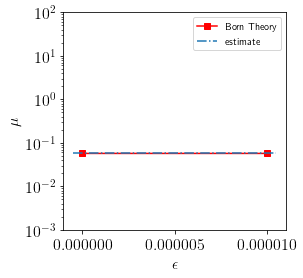

In [1109]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')
ax.set_ylim(1e-3,1e2)
#ax.set_ylim(1e2,1e3)
#ax.set_ylim(1e0,1e2)
#ax.set_ylim(1e2,1e3)
#ax.set_ylim(1e5,1e7)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- plot mu
ax.plot(np.array(strain),abs(np.array(mu)),'-rs', label='Born Theory')

#--- plot stress
#ax.plot(2*np.array(strain),np.array(virial),'-o')
#ax.plot(2*np.array(strain),np.gradient(virial,2*np.array(strain)),'-o')
ax.plot(ax.axis()[:2],[ abs(coeffs[0]), abs(coeffs[0]) ],'-.', label='estimate')
#
ax.legend()
#
plt.savefig('bornModulus.png',dpi=75,bbox_inches='tight')
plt.show()

In [281]:
print mu, coeffs[0]

[-2.2656849661673135, -2.3204437950625287, -2.3734627324859137, -2.4247826600026823, -2.474443549924713, -2.5224844849845063, -2.568943677619881, -2.613858488864171] -9.868363482111098


### change in sigma

In [1180]:
import math

Ri=np.random.random(3)
Ri[0]=0.25;Ri[2]=0.0
ri=Ri[:]
rj=np.array([0,0,0]) #np.random.random(3)
Rj=rj[:]
rk=np.array([0.5,0,0])#random.random(3)
Rk=rk[:]
scaleij = 1.0
ddUdrijmds = np.zeros(3)
dUdrijm = np.zeros(3)
ddUdrmdrn = np.zeros(6)
f = np.zeros(2*3).reshape((2,3))
ddUdrdrijm=np.zeros(3)
vatom = np.zeros(2*(6+21)).reshape((2,6+21))
fi = np.zeros(3)
v=np.zeros(6)
vm=np.zeros(21)

virial = []
mu = []
strain = []

Rij=[]
dscrfcnn=[]
ddscrfcnn=[]
SIJ=[]

theta=0
for eps in np.linspace(0,.00001,2):
    
    f[0][:]=0.0
    f[1][:]=0.0
    vatom[0][:]=0.0
    vatom[1][:]=0.0


    print 'eps=',eps
#     F=np.array([[1.0+eps,0,0],
#           [0,1,0],
#           [0,0,1]])
    F=np.array([[1.0,eps,0],
          [0,1,0],
          [0,0,1]])
    i=0
    j=1
    ri=np.matmul(F,Ri) #+np.array([dx,0.0,0.0])
    rj = Rj[:]
    rk = Rk[:]
    #---rotate
#     ri = np.matmul(rot(+theta),Ri-Rk)+Rk
#     rj = np.matmul(rot(-theta),Rj-Rk)+Rk
#     rk = Rk
# #    print 'ri=',ri
#     theta=0.00001*pi*1.0/180   
    
    delij = rj-ri
    delik = rk-ri
    deljk = rk-rj
    rij = np.sum(delij * delij)**0.5  
    rjk = np.sum(deljk * deljk)**0.5  
    rik = np.sum(delik * delik)**0.5  
    ndir = delij / rij
#     print 'ri[1]',ri[1]
#     print 'rij=',rij
#     print 'rjk=',rjk
#    print 'rik=',rik
#    theta = math.atan2(rjk,rij)
#    print 'theta=',180*theta/pi
    
    if eps >0.0:
        drij = rij-rij0
        drjk = rjk-rjk0
        drik = rik-rik0
        dnm = ndir - ndir0
        print 'drij=',drij
        drijm = delij - delij0
    recip = 1/rij
    print 'drjk=',drjk
    scrfcn, dscrfcn, ddscrfcn, fcpair = GetScreen(ri,rj,rk)
    
    Rij+=[rij]
    dscrfcnn+=[dscrfcn]
    ddscrfcnn+=[ddscrfcn]
    
#    print scrfcn, dscrfcn, ddscrfcn, fcpair
    
    r3 = rij*rij*rij;
    sij = scrfcn * fcpair;
#    sij = rij*rij;
    if eps >0.0:
        dsij=sij-sij0
        print 'dsij=',dsij
    ds = dscrfcn * rij;
#    ds = 2*rij;dscrfcn=ds/rij;
    dds = ddscrfcn;
#    dds = 2.0;
#    print 'sij=',sij
    SIJ+=[sij]
    
    dUdrij = 0.0;
    ddUddrij = 0.0;
    dUdsij = 0.0;
    ddUddsij = 0.0;
    for m in xrange(3): ddUdrijmds[m] = 0.0;
    ddUdrijds = 0.0;
    assert not iszero(dscrfcn)
    if 1: #not iszero(dscrfcn):
        dUdsij = 1.0;
        ddUddsij = 0.0;
        for m in xrange(3): ddUdrijmds[m] = 0.0;
        ddUdrijds = 0.0;
        nv2 = 0;
        for m in xrange(3):
            dUdrijm[m] = 0.0;
            ddUdrdrijm[m] = 0.0
            for n in xrange(m,3):
                ddUdrmdrn[nv2] =  0.0;
                nv2 +=1;
            
          
         
    if not isone(scaleij):
        dUdrij *= scaleij;
        dUdsij *= scaleij;
        dUdrijm[0] *= scaleij;
        dUdrijm[1] *= scaleij;
        dUdrijm[2] *= scaleij;
        
        ddUddrij *= scaleij;
        for m in xrange(3): ddUdrdrijm[m] *= scaleij;
        for m in xrange(6): ddUdrmdrn[m] *= scaleij;
        
        ddUddsij *= scaleij;
        ddUdrijds *= scaleij;
        for m in xrange(3): ddUdrijmds[m] *= scaleij;
        

    force = dUdrij * recip + dUdsij * dscrfcn;
    for m in xrange(3):
        forcem = delij[m] * force + dUdrijm[m];
        f[i][m] = f[i][m] + forcem;
        f[j][m] = f[j][m] - forcem;

    
    
    n0 = delij[0] * recip;
    n1 = delij[1] * recip;
    n2 = delij[2] * recip;        

    fi[0] = delij[0] * force + dUdrijm[0];
    fi[1] = delij[1] * force + dUdrijm[1];
    fi[2] = delij[2] * force + dUdrijm[2];
    v[0] = 0.5 * (delij[0] * fi[0]);
    v[1] = 0.5 * (delij[1] * fi[1]);
    v[2] = 0.5 * (delij[2] * fi[2]);
    v[3] = 0.25 * (delij[0] * fi[1] + delij[1] * fi[0]);
    print 'sym?',delij[0] * fi[1], delij[1] * fi[0]
    v[4] = 0.25 * (delij[0] * fi[2] + delij[2] * fi[0]);
    v[5] = 0.25 * (delij[1] * fi[2] + delij[2] * fi[1]);
    nv2 = 0;
    for m in xrange(6):
        vatom[i][m] = vatom[i][m] + v[m];
        vatom[j][m] = vatom[j][m] + v[m];
        nv2 += 1;
        
        
    alpha = 0    
    beta = 1    
    if eps == 0.0:
        dsg_alpha_beta_dr, dsg_alpha_beta_ds, dsg_alpha_beta_drm, ddscrfcndrik, ddscrfcndrjk=\
        GetDeriv( ri,  rj, rk,  sij,
                 alpha,  beta,   r3, ds,  dds,  recip,
                 dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
                 dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn)
        
#--- sig=(ds/drij) n[alpha] r[beta]
#         ndir = delij/rij
#         dsigdrij = dds*ndir[alpha]*delij[beta]    
#         dsigdrjk = ddscrfcndrjk*ndir[alpha]*delij[beta]    
#         dsigdrik = ddscrfcndrik*ndir[alpha]*delij[beta]
#         dsigdnm = ds * delij[beta]
        
        dsigdrij = ((-1/rij/rij)*ds+(1/rij)*dds)* delij[alpha]*delij[beta]
        dsigdrjk = (1/rij)*ddscrfcndrjk*delij[alpha]*delij[beta]    
        dsigdrik = (1/rij)*ddscrfcndrik*delij[alpha]*delij[beta]  
        dsigdrijm = (1/rij)*ds*delij[beta]
        dsigdrijm2 = (1/rij)*ds*delij[alpha]
        
    else:
#         print 'dsigdrij=',dsg_alpha_beta_dr
#         print 'dsigdsij=',dsg_alpha_beta_ds
#         print 'dsigdrijm',dsg_alpha_beta_drm
#         print 'dsig_estimate=',dsg_alpha_beta_dr*drij+np.sum(dsg_alpha_beta_drm*drijm)+dsg_alpha_beta_ds*dsij
#        print 'dsig_estimate=',dsigdrij*drij+dsigdrjk*drjk+dsigdrik*drik+ dsigdnm * dnm[alpha]
#        print 'dsig_estimate=', dsigdrij*drij+dsigdrjk*drjk+dsigdrik*drik+ dsigdrijm * drijm[alpha]
        print 'dsig_estimate=',\
        dsigdrij*drij+dsigdrjk*drjk+dsigdrik*drik+dsigdrijm * drijm[alpha]
        print '0?',dsigdrijm2 * drijm[beta]
    #0.5*(dsigdrijm * drijm[alpha]+dsigdrijm2 * drijm[beta])
        #---- modulus
#    print sij
#     vm[ 0 ]  = -0.5* GetModulus( ri,  rj,  sij,
#                          0,0,0,0,   r3, ds,  dds,  recip,
#                          dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
#                          dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn)
#     vm[ 15 ]  = 0.5* GetModulus( ri,  rj,  sij,
#                          0,1,0,1,   r3, ds,  dds,  recip,
#                          dUdrij,  dUdsij,  ddUddrij,  ddUdrijds,  ddUddsij,
#                          dUdrijm,  delij,  ddUdrdrijm,  ddUdrijmds,  ddUdrmdrn)

#     nv3 = 0;
#     nv2 = 6;
#     for m in xrange(6):
#         for n in xrange(m,6):
#             vatom[i][nv2] += vm[nv3];
#             vatom[j][nv2] += vm[nv3];
#             nv2+=1;
#             nv3+=1;
        
    sigma = vatom[0][4-1]+vatom[1][4-1]
    istre = 0
#    virial += [vatom[0][1-1]+vatom[1][1-1]]
    virial += [vatom[0][4-1]+vatom[1][4-1]]
#    mu += [vatom[0][7-1]+vatom[1][7-1]]
#    mu += [vatom[0][22-1]+vatom[1][22-1]]
    #--- strain
    strain += [eps]
    
    if eps >0.0:
        print 'dsigma=',sigma-sigma0
    
    
    rij0=rij
    rjk0=rjk
    rik0=rik
    ndir0=ndir
    delij0=delij
    sij0=sij
    sigma0 = sigma
#


        
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# #ax2 = ax.twinx()
# ax.set_xlabel(r'$\epsilon$',fontsize=16)
# ax.set_ylabel(r'$\sigma$',fontsize=16)
# ax.tick_params(labelsize=16)
# #--- plot stress
# ax.plot(np.array(strain),np.array(virial),'-o')
# #--- fit
# coeffs = np.polyfit(np.array(strain)[1:],np.array(virial)[1:], 1)
# def func(x, m, b):
#     return m*x+b
# print 'slope',coeffs[0]
# #--- print fit
# ax.plot(np.array(strain),func(np.array(strain), *coeffs),'-.r')
# #plt.savefig('stressStrain.png',dpi=75,bbox_inches='tight')
# plt.show()

eps= 0.0
drjk= 0.0
sym? -0.11889242076778357 -0.11889242076778357
eps= 1e-05
drij= 1.973633906471317e-06
drjk= 0.0
dsij= -8.348288807746851e-07
sym? -0.11889136508005399 -0.11889136508005399
dsig_estimate= 1.055656014731395e-06
0? 0.0
dsigma= 1.0556877295814227e-06


In [1183]:
Rk

array([0.5, 0. , 0. ])

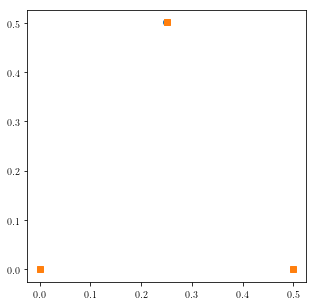

In [1013]:
plt.figure(figsize=(5,5))
plt.plot([Ri[0],Rj[0],Rk[0]],[Ri[1],Rj[1],Rk[1]],'o')
plt.plot([ri[0],rj[0],rk[0]],[ri[1],rj[1],rk[1]],'s')
plt.show()

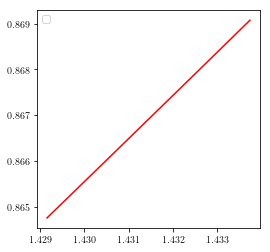

In [41]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax2=ax.twinx()

#ax.set_xlim(0.99,1)
#ax.set_ylim(-10,+10)
#ax2.set_xlim(0.8,1)
#ax.set_yscale('log')
#ax2.set_yscale('log')
#rij=xx #[:,0]

#ax.plot(rij,DSIJ,'o')

# ax2.plot(rij,np.gradient(SIJ,rij),'ro')
# ax2.plot(rij,dscrfcn*rij,'-')
rij=np.array(Rij)
sij=np.array(SIJ)
dscrfcn=np.array(dscrfcnn)
ddscrfcn=np.array(ddscrfcnn)

ax.plot(rij,sij,'-',color='red')


#ax.plot(rij,np.gradient(sij,rij,edge_order=2),'o',label='real',color='black')
#ax.plot(rij,dscrfcn*rij,'-',color='red')


# ax.plot(rij,np.gradient(dscrfcn*rij,rij),'o',label='real',color='black')
# ax.plot(rij,ddscrfcn,'-',color='red')
ax.legend()
#ax2.plot(rij,ddfcij,'o')
plt.show()

In [40]:
dscrfcn

array([0.42338097, 0.42329457, 0.42320841, 0.4231225 , 0.42303682,
       0.42295139, 0.42286621, 0.42278126])

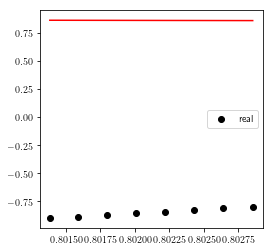

In [23]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax2=ax.twinx()

#ax.set_xlim(0.99,1)
#ax.set_ylim(-10,+10)
#ax2.set_xlim(0.8,1)
#ax.set_yscale('log')
#ax2.set_yscale('log')
#rij=xx #[:,0]

#ax.plot(rij,DSIJ,'o')

# ax2.plot(rij,np.gradient(SIJ,rij),'ro')
# ax2.plot(rij,dscrfcn*rij,'-')
rij=np.array(Rij)
sij=np.array(SIJ)
dscrfcn=np.array(dscrfcnn)
ddscrfcn=np.array(ddscrfcnn)

# ax.plot(rij,np.gradient(sij,rij),'o',label='real',color='black')
# ax.plot(rij,dscrfcn*rij,'-',color='red')


ax.plot(rij,np.gradient(dscrfcn*rij,rij),'o',label='real',color='black')
ax.plot(rij,ddscrfcn,'-',color='red')
ax.legend()
#ax2.plot(rij,ddfcij,'o')
plt.show()

In [223]:
SIJ

[0.0030897485374540234,
 0.0030716402065269744,
 0.0030536291687668408,
 0.003035714769520837,
 0.0030178963605271224,
 0.0030001732998364413,
 0.002982544951735429,
 0.0029650106866709537]

In [244]:
ddscrfcn

array([7.31405474e-07, 7.31405474e-07, 7.31405474e-07, 7.31405474e-07,
       7.31405474e-07, 7.31405474e-07, 7.31405474e-07, 7.31405474e-07])

In [205]:
np.diff(rij)

array([6.73221113e-06, 6.78792354e-06, 6.84363410e-06, 6.89934280e-06,
       6.95504962e-06, 7.01075454e-06, 7.06645755e-06])

In [10]:
def dfcut(xi):
    if (xi >= 1.0):
        dfc = 0.0;
        ddfc = 0.0;
        return 1.0,dfc,ddfc;
    elif (xi <= 0.0):
        dfc = 0.0;
        ddfc = 0.0;
        return 0.0,dfc,ddfc;
    else:
        a = 1.0 - xi;
        a3 = a * a * a;
        a4 = a * a3;
        a1m4 = 1.0-a4;

        dfc = 8 * a1m4 * a3;
        ddfc = 8*(-3*a*a*a1m4+4*a3*a3);
        return a1m4*a1m4,dfc,ddfc;




# n=100
# rij=np.linspace(0,1,n)
# dr = 0.5
# drinv = 1/dr
# rc=1.0

# fcij=np.zeros(n)
# dfcij=np.zeros(n)
# ddfcij=np.zeros(n)
# for rr,indx in zip(rij,xrange(sys.maxint)):
#     rnorm = (rc-rr)/dr
#     fc,dfc, ddfc = dfcut(rnorm );
#     fcij[indx] = fc;
#     dfcij[indx] = dfc * drinv; 
#     ddfcij[indx] = ddfc * drinv * drinv; 



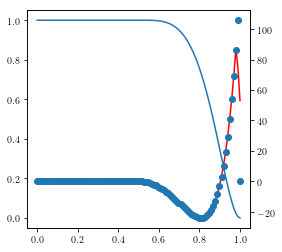

In [19]:
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax2=ax.twinx()

# ax.plot(rij,fcij)
# #ax2.plot(rij,np.gradient(fcij,rij),'r')
# #ax2.plot(rij,-dfcij,'o')
# ax2.plot(rij,np.gradient(np.gradient(fcij,rij),rij),'r')
# ax2.plot(rij,ddfcij,'o')
# plt.show()

### test derivatives

In [1175]:
from math import *
      


n=1000

Cmax=1.0e2
Cmin=1e-6

Rij=[]
Rik=[]
Rjk=[]
dscrfcnn=[]
ddscrfcnn=[]
SIJ=[]
dsijdrik =[]
ddsijdrikdrij =[]
    
rj=np.random.random(3)
rj[2]=0.0
#rj=np.array([0,0,0])
#rk=np.array([0.5,0,0])
rk=np.random.random(3)
rk[2]=0.0
ri=np.random.random(3)
ri[2]=0.0

#ri=np.array([0.5,0.5,0.0])
#dx = 1.0/n

rot=lambda theta:  np.array([[cos(theta),-sin(theta),0],
                             [sin(theta),cos(theta),0],
                             [0,0,1]])
theta=0
for i in xrange(n):
    theta+=pi*1.0/180   
    ri_rot = np.matmul(rot(+theta),ri-rk)+rk
    rj_rot = np.matmul(rot(-theta),rj-rk)+rk
    
    delij = rj_rot-ri_rot
    deljk = rk-rj_rot
    delik = rk-ri_rot
    rij = np.sum(delij * delij)**0.5  
    rjk = np.sum(deljk * deljk)**0.5  
    rik = np.sum(delik * delik)**0.5  
    
    
    scrfcn, dscrfcn, ddscrfcn, fcpair = GetScreen(ri_rot.copy(),rj_rot.copy(),rk)
    
    sij = scrfcn * fcpair;
    ds = dscrfcn * rij;
    dds = ddscrfcn;

    Rik+=[rik]
    Rjk+=[rjk]
    Rij+=[rij]
    SIJ+=[sij]
    dscrfcnn+=[ds]
    ddscrfcnn+=[dds]

    
    dsij1, dsij2, ddsij1drij, ddsij2drij=GetDeriv( ri_rot,  rj_rot,  rk, sij,
                         0,  0,   rij*rij*rij, ds,  dds,  1/rij,
                         0,  0,  0,  0,  1/rij,
                         0,  delij,  0,  0,  0, RETURN=True)
    dsijdrik += [dsij1]
    ddsijdrikdrij += [ddsij1drij]

    print i#, rij, ddsij1drij


0
1
2
3
4
5
6
7


AssertionError: a=-0.07631707151709688

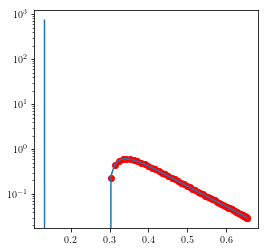

In [855]:
#--- sort
def sortfunc(rij,dsijdrik):
    slist=zip(rij,dsijdrik)
    slist.sort()
    rij=[i[0] for i in slist]
    dsijdrik=[i[1] for i in slist]
    return rij, dsijdrik

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

#ax.set_ylim(1,1e7)
ax.set_yscale('log')
minus=-1
rij = Rij[:]
rij, dsijdrik = sortfunc(rij,dsijdrik)

#ax.plot(rij,dsijdrik,'bs')
ax.plot(rij,minus*np.gradient(dsijdrik,rij),'ro')
ax.plot(Rij,minus*np.array(ddsijdrikdrij),'-')

plt.show()

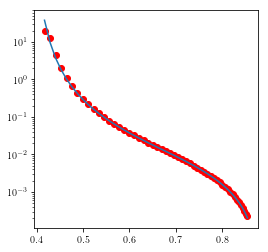

In [538]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

#ax.set_xlim(0.0,1)
#ax.set_ylim(-.5,0)
ax.set_yscale('log')
rij=Rij 


ax.plot(rij,-np.gradient(SIJ,rij),'ro')
ax.plot(rij,-np.array(dscrfcnn),'-')

plt.show()

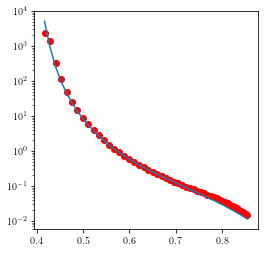

In [539]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

#ax.set_xlim(0.0,1)
ax.set_yscale('log')
rij=Rij 


#ax.plot(rij,np.gradient(np.gradient(SIJ,rij),rij),'ro')
ax.plot(rij,np.gradient(dscrfcnn,rij),'ro')
ax.plot(rij,ddscrfcnn,'-')

plt.show()

### density

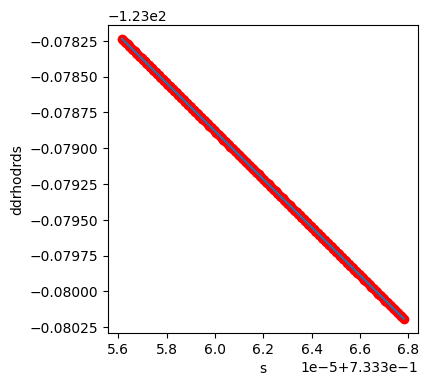

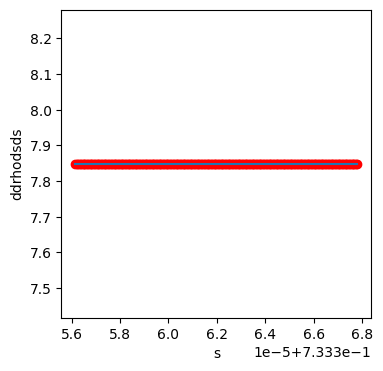

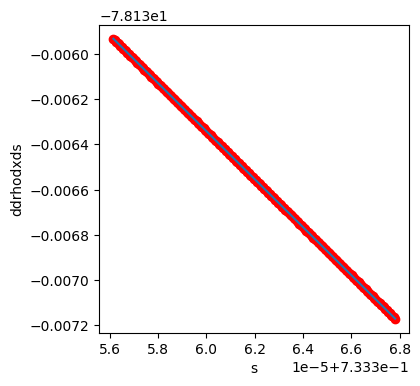

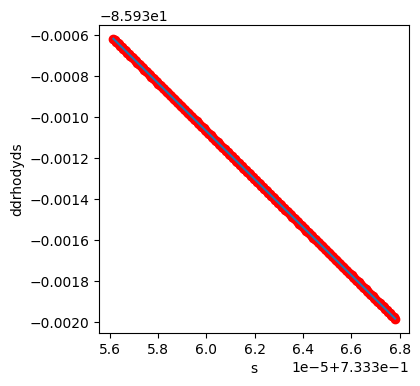

In [92]:
sarr=np.loadtxt('%s/myfile.txt'%path)
df=pd.DataFrame(np.c_[sarr],
                columns=['s','rho','drhodr','drhods','drhodx','drhody','drhodz',
                                 'ddrhodrds', 'ddrhodsds','ddrhodxds','ddrhodyds','ddrhodzds'])

df.sort_values(by='s',inplace=True)

for i1,i2 in zip(['drhodr' ,'drhods','drhodx','drhody'],['ddrhodrds','ddrhodsds','ddrhodxds','ddrhodyds']):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(df['s'],df[i2],'-',zorder=2)
    xlim=ax.axis()
    ax.plot(df['s'],np.gradient(df[i1],df['s'],edge_order=2),'ro',zorder=1)
    ax.axis(xlim)
    ax.set_xlabel('s')
    ax.set_ylabel(i2)
    plt.show()



In [93]:
df

,s,rho,drhodr,drhods,drhodx,drhody,drhodz,ddrhodrds,ddrhodsds,ddrhodxds,ddrhodyds,ddrhodzds
0,0.733356,2.110560,-45.130091,5.755893,-28.650733,-31.508875,0.0,-123.078236,7.848701,-78.135931,-85.930620,0.0
1,0.733356,2.110560,-45.130098,5.755894,-28.650738,-31.508880,0.0,-123.078246,7.848701,-78.135937,-85.930626,0.0
2,0.733356,2.110561,-45.130106,5.755894,-28.650742,-31.508885,0.0,-123.078256,7.848701,-78.135944,-85.930633,0.0
3,0.733356,2.110561,-45.130113,5.755895,-28.650747,-31.508890,0.0,-123.078265,7.848701,-78.135950,-85.930640,0.0
4,0.733356,2.110561,-45.130120,5.755895,-28.650751,-31.508895,0.0,-123.078275,7.848701,-78.135956,-85.930647,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.733368,2.110626,-45.131496,5.755983,-28.651625,-31.509856,0.0,-123.080152,7.848701,-78.137148,-85.931957,0.0
197,0.733368,2.110626,-45.131503,5.755983,-28.651630,-31.509861,0.0,-123.080162,7.848701,-78.137154,-85.931964,0.0
198,0.733368,2.110626,-45.131511,5.755984,-28.651634,-31.509866,0.0,-123.080172,7.848701,-78.137160,-85.931971,0.0
199,0.733368,2.110627,-45.131518,5.755984,-28.651639,-31.509871,0.0,-123.080181,7.848701,-78.137166,-85.931978,0.0


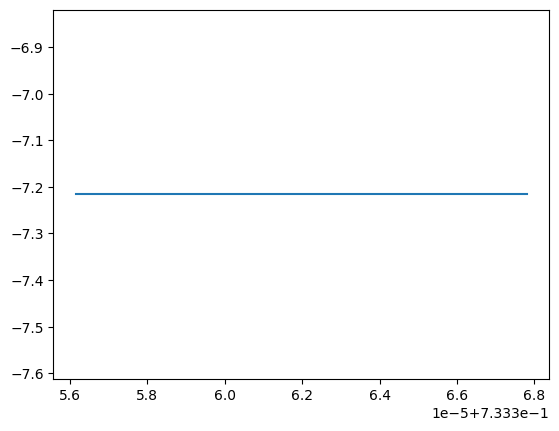

In [66]:
plt.plot(df['s'],df['ddrhodrds'])
plt.show()

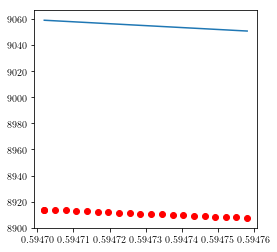

In [620]:
sarr=np.loadtxt('%s/myfile.txt'%path)
# df=pd.DataFrame(np.c_[sarr],columns=['x','y','r','s','rhoa','drhoa','ddrhoa','rho2',\
#                                      'dydr','dydx','ddydrdr','ddydxdr','ddydxdx','sigma','cxyxy'])#.iloc[1:]
df=pd.DataFrame(np.c_[sarr],columns=['x','y','r','s','rhoa','drhoa','ddrhoa','dyds', 'ddydsds'])
#df=df[df['r']<.7] #!!!!!!!!!!!!!!!!!!!!!
#df.sort_values(by='x',inplace=True)
#df=df.sample(n=100)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax2=ax.twinx()
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
#ax.set_yscale('log')

#dydx = 3*(df['r']**2)**2*2*df['x']/df['r']**6 - (3.0/5)*2*df['x']/df['r']**2 #4.8*df['x']/df['r']**2 #
#dy = 3*df['r']**4*2*df['x']/df['r']**6 - (3.0/5)*2*df['x']/df['r']**2
#ddy = 6*(4*(df['r']*df['x'])**2+df['r']**4)/df['r']**6-6/5.0/df['r']**2
#
#dy = -6/df['r']+1.2/df['r'] 
#ddy = 42/df['r']**2-3.6/df['r']**2 
rho2=(df['rhoa']*df['s']/df['r']**2)**2*df['r']**4-(df['rhoa']*df['s'])**2/3
dydx= 4*(df['rhoa']*df['s']/df['r']**2)**2*df['x']*df['r']**2
dydr=df['r']**4*2*df['s']**2*(df['rhoa']/df['r']**2)*(df['drhoa']/df['r']**2-\
    2*df['rhoa']/df['r']**3)-(2*df['s']**2/3)*df['rhoa']*df['drhoa']

dyds=2*df['s']*(df['rhoa']/df['r']**2)**2*df['r']**4-(df['rhoa']**2/3)*2*df['s']
ddydsds=2*(df['rhoa']/df['r']**2)**2*df['r']**4-(df['rhoa']**2/3)*2
ddydrdr=df['r']**4*2*df['s']**2*((df['drhoa']/df['r']**2-2*df['rhoa']/df['r']**3)*(df['drhoa']/df['r']**2-2*df['rhoa']/df['r']**3)+\
        (df['rhoa']/df['r']**2)*(df['ddrhoa']/df['r']**2-2*df['drhoa']/df['r']**3-2*df['drhoa']/df['r']**3+6*df['rhoa']/df['r']**4))-\
        (2*df['s']**2/3)*(df['drhoa']**2+df['rhoa']*df['ddrhoa'])
ddydxdx = 4*(df['rhoa']*df['s']/df['r']**2)**2*(df['r']**2+2*df['x']**2)
ddydxdr = 4*df['s']**2*df['x']*df['r']**2*(2*df['rhoa']/df['r']**2)*(df['drhoa']/df['r']**2-\
                        2*df['rhoa']/df['r']**3)


# sigma = ((1/df['r'])*(df['dydr'])*df['x']+df['dydx'])*df['y']
# dsigmadr=(df['x']*((-1/df['r']**2)*df['dydr']+df['ddydrdr']/df['r'])+df['ddydxdr'])*df['y']
# dsigmadx=((df['ddydxdr']*df['x']+df['dydr'])/df['r']+df['ddydxdx'])*df['y']
# cxyxy=((1/df['r'])*dsigmadr*df['x']+dsigmadx)*df['y']

sigma = ((1/df['r'])*(dydr)*df['x']+dydx)*df['y']
dsigmadr=(df['x']*((-1/df['r']**2)*dydr+ddydrdr/df['r'])+ddydxdr)*df['y']
dsigmadx=((ddydxdr*df['x']+dydr)/df['r']+ddydxdx)*df['y']
cxyxy=((1/df['r'])*dsigmadr*df['x']+dsigmadx)*df['y']


# ax.plot(df['r'],df['rho2'],'ro')
# ax.plot(df['r'],rho2,'-')

# minus = 1
ax.plot(df['r'],df['dyds'],'ro')
ax.plot(df['r'],dyds,'-')

# ax.plot(df['r'],minus*np.gradient(df['rhoa'],df['r']),'ro')
# ax.plot(df['r'],minus*df['drhoa'],'-')

#ax.plot(df['r'],df['rhoa'],'-')


vol=1#50**3

# ax.plot(df['r'],df['sigma'],'ro')
# ax.plot(df['r'],sigma,'-')

# ax.plot(df['r'],df['cxyxy'],'ro')
# ax.plot(df['r'],cxyxy,'-')


plt.show()

In [622]:
df.head(n=32)

,x,y,r,s,rhoa,drhoa,ddrhoa,dyds,ddydsds
0,-0.400088,-0.44,0.594702,0.733356,96.25330,-231.9357,558.8811,8913.894,12352.93
1,-0.400088,-0.44,0.594702,0.733356,96.25330,-231.9357,558.8811,8913.894,12352.93
2,-0.400092,-0.44,0.594705,0.733331,96.25261,-231.9340,558.8771,8913.558,12352.75
3,-0.400097,-0.44,0.594708,0.733307,96.25193,-231.9324,558.8731,8913.223,12352.58
4,-0.400101,-0.44,0.594711,0.733282,96.25124,-231.9307,558.8692,8912.887,12352.40
5,-0.400106,-0.44,0.594714,0.733257,96.25055,-231.9290,558.8652,8912.552,12352.23
6,-0.400110,-0.44,0.594717,0.733232,96.24987,-231.9274,558.8612,8912.216,12352.05
7,-0.400114,-0.44,0.594720,0.733207,96.24918,-231.9257,558.8572,8911.881,12351.87
8,-0.400119,-0.44,0.594723,0.733183,96.24849,-231.9241,558.8532,8911.545,12351.70
9,-0.400123,-0.44,0.594726,0.733158,96.24781,-231.9224,558.8492,8911.210,12351.52


### rho3

In [329]:
def junkFunc(delij):
    rij = np.sum(delij*delij)**.5
    rij2 = rij * rij;
    rij3 = rij * rij2;
    rij4 = rij2 * rij2;
    a3 = 6.0;#//* sij / rij3;
    a3a = 1.2;#//6.0 * sij / (5 * rij);
    a3b = 1;#//rhoa3j * sij / rij3;
    a3c = 1;#//rhoa3j * sij / rij;

    deltamn=np.array([[1,0,0],[0,1,0],[0,0,1]])
    v2D=np.array([[1,0,0],[0,1,0],[0,0,1]])
    
    nv2 = 0;
    ddrho3drmdrn1=np.zeros(6)
    for m in xrange(3):
        for n in xrange(m,3): 
            ddrho3drmdrn1[nv2] = a3*(a3b*(rij4*deltamn[m,n]+2*rij2*delij[m]*delij[n])+2*a3b*rij2*delij[m]*delij[n])-a3a*a3c*deltamn[m,n]; 
            nv2+=1;


    nv2 = 0;
    ddrho3drmdrn1=np.zeros(6)
    for m in xrange(3):
        for k in xrange(m,3):
            ddrho3drmdrn1[nv2]=0.0;
            for n in xrange(3):
                for p in xrange(n,3):
                    arg = delij[n] * delij[p] * this->v2D[nv2];
                    dargdk = (( k == n ? 1 : 0 ) * delij[p]+delij[n] * ( p == k ? 1 : 0 )) * this->v2D[nv2];
                    darho3imnpdk = a3b * (( k == m ? 1 : 0 )*delij[n]*delij[p] +\
                                                   delij[m]*( k == n ? 1 : 0 )*delij[p] +\
                                                   delij[m]*delij[n]*( k == p ? 1 : 0 ));
                    ddrho3drmdrn1[nv2] += darho3imnpdk * arg + arho3[i][this->vind3D[m][n][p]] * dargdk;


            darho3bimdrk =  a3c * ( m == k ? 1 : 0 ); //--- darho3b[i][m]/drk
            ddrho3drmdrn1[nv2] = a3 * rhoa3j * ddrho3drmdrn1[nv2] - a3a * rhoa3j * darho3bimdrk;
            nv2 = nv2 + 1;

junkFunc(np.array([1,1,1]))

   

SyntaxError: invalid syntax (<ipython-input-329-109ec0b5bd53>, line 28)

In [701]:
from sympy import *
import sympy


sarr=np.loadtxt('%s/myfile.txt'%path)
# df=pd.DataFrame(np.c_[sarr],columns=['x','y','r','s','rhoa','drhoa','ddrhoa','rho2',\
#                                      'dydr','dydx','ddydrdr','ddydxdr','ddydxdx','sigma','cxyxy'])#.iloc[1:]
df=pd.DataFrame(np.c_[sarr],columns=['x01','y01','z01','r01','s01','rhoa1',
                                     'x02','y02','z02','r02','s02','rhoa2', 
                                     'rho2',
                                    'ddUddrij','ddUdrijds','ddUddsij','ddUdrdrij0','ddUdrij0ds','ddUdr0dr0'
                                    ])


x01, y01, z01, r01, x02, y02, z02, r02  = symbols('x01 y01 z01 r01 x02 y02 z02 r02')

Y00=df['rhoa1']*x01*x01/r01**2*df['s01']+df['rhoa2']*x02*x02/r02**2*df['s02']
Y01=df['rhoa1']*x01*y01/r01**2*df['s01']+df['rhoa2']*x02*y02/r02**2*df['s02']
Y02=df['rhoa1']*x01*z01/r01**2*df['s01']+df['rhoa2']*x02*z02/r02**2*df['s02']

Y10=df['rhoa1']*y01*x01/r01**2*df['s01']+df['rhoa2']*y02*x02/r02**2*df['s02']
Y11=df['rhoa1']*y01*y01/r01**2*df['s01']+df['rhoa2']*y02*y02/r02**2*df['s02']
Y12=df['rhoa1']*y01*z01/r01**2*df['s01']+df['rhoa2']*y02*z02/r02**2*df['s02']

Y20=df['rhoa1']*z01*x01/r01**2*df['s01']+df['rhoa2']*z02*x02/r02**2*df['s02']
Y21=df['rhoa1']*z01*y01/r01**2*df['s01']+df['rhoa2']*z02*y02/r02**2*df['s02']
Y22=df['rhoa1']*z01*z01/r01**2*df['s01']+df['rhoa2']*z02*z02/r02**2*df['s02']

w=df['rhoa1']*df['s01']+df['rhoa2']*df['s02']

     
rho2=Y00**2+Y01**2+Y02**2+Y10**2+Y11**2+Y12**2+Y20**2+Y21**2+Y22**2-w**2/3
ddUdr0dr0 = rho2.apply(lambda x:diff(x,x01,2))

In [702]:
df.head()

,x01,y01,z01,r01,s01,rhoa1,x02,y02,z02,r02,s02,rhoa2,rho2,ddUddrij,ddUdrijds,ddUddsij,ddUdrdrij0,ddUdrij0ds,ddUdr0dr0
0,-0.400088,-0.44,0.0,0.594702,0.733356,96.25330,0.099912,-0.44,0.0,0.451201,1.0,136.0155,15548.76,891560.6,-164210.0,12352.93,213045.5,0.0,112689.3
1,-0.400088,-0.44,0.0,0.594702,0.733356,96.25330,0.099912,-0.44,0.0,0.451201,1.0,136.0155,15548.76,891560.6,-164210.0,12352.93,213045.5,0.0,112689.3
2,-0.400092,-0.44,0.0,0.594705,0.733331,96.25261,0.099908,-0.44,0.0,0.451200,1.0,136.0158,15548.62,891493.5,-164203.4,12352.75,213027.6,0.0,112679.3
3,-0.400097,-0.44,0.0,0.594708,0.733307,96.25193,0.099903,-0.44,0.0,0.451199,1.0,136.0161,15548.48,891426.5,-164196.7,12352.58,213009.7,0.0,112669.4
4,-0.400101,-0.44,0.0,0.594711,0.733282,96.25124,0.099899,-0.44,0.0,0.451198,1.0,136.0164,15548.34,891359.4,-164190.1,12352.40,212991.8,0.0,112659.4


In [703]:
def func_eval(rho2,df):
    n=len(df)
    rho2_eval=np.zeros(n)
    for item,index in zip(rho2.iteritems(),xrange(sys.maxint)):
        f=df.iloc[index]
        rho2_eval[index]=item[1].subs([(x01,f['x01']), (y01,f['y01']), (z01,f['z01']),(r01,f['r01']), 
                                       (x02,f['x02']), (y02,f['y02']), (z02,f['z02']),(r02,f['r02'])])
    return rho2_eval
    
rho2_eval = func_eval(rho2,df)
ddUdr0dr0_eval = func_eval(ddUdr0dr0,df)




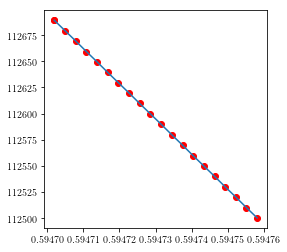

In [704]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)


# minus = 1
ax.plot(df['r01'],df['ddUdr0dr0'],'ro')
ax.plot(df['r01'],ddUdr0dr0_eval,'-')

# ax.plot(df['r'],minus*np.gradient(df['rhoa'],df['r']),'ro')
# ax.plot(df['r'],minus*df['drhoa'],'-')

#ax.plot(df['r'],df['rhoa'],'-')


vol=1#50**3

# ax.plot(df['r'],df['sigma'],'ro')
# ax.plot(df['r'],sigma,'-')

# ax.plot(df['r'],df['cxyxy'],'ro')
# ax.plot(df['r'],cxyxy,'-')


plt.show()

NameError: name 'Rij' is not defined

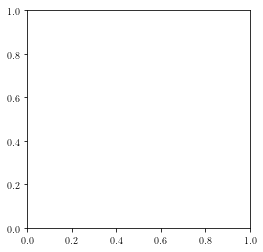

In [680]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax2=ax.twinx()

#ax.set_xlim(0.8,1)
#ax.set_ylim(-10,+10)
#ax2.set_xlim(0.8,1)
#ax.set_yscale('log')
#ax2.set_yscale('log')
#rij=xx #[:,0]

#ax.plot(rij,DSIJ,'o')

# ax2.plot(rij,np.gradient(SIJ,rij),'ro')
# ax2.plot(rij,dscrfcn*rij,'-')
rij=Rij
ax.plot(rij,np.gradient(np.gradient(dscrfcnn,rij),rij),'o',label='real')
ax.plot(rij,ddscrfcnn,'s')
ax.legend()
#ax2.plot(rij,ddfcij,'o')
plt.show()

In [29]:
# def dCfunc(rij2, rik2, rjk2):

#     rij4 = rij2 * rij2;
#     a = rik2 - rjk2;
#     b = rik2 + rjk2;
#     asq = a*a;
#     denom = rij4 - asq;
#     denom = denom * denom;
#     return -4 * (-2 * rij2 * asq + rij4 * b + asq * b) / denom


# def ddCfunc(rij,  rij2,  rik2, rjk2):

#     rij4 = rij2 * rij2;
#     rij3 = rij2 * rij;
#     a = rik2 - rjk2;
#     b = rik2 + rjk2;
#     asq = a*a;
#     denom = rij4 - asq;
#     denom = denom * denom;
#     ddenom = 2*(rij4-asq)*(4*rij3);

#     dcikj = dCfunc(rij2, rik2, rjk2);
#     ddcikj = -4 * (-2 * 2 * rij * asq + 4*rij3 * b ) - dcikj * ddenom;
#     ddcikj /= denom;

#     return ddcikj * rij+dcikj;    

# #n=10
# rik2 = 0.1;rjk2 = 0.34
# rij=np.linspace(0.1,1.0,n)

# dCikj=np.zeros(n)
# ddCikj=np.zeros(n)
# for xitem,indx in zip(xx,xrange(sys.maxint)):
#     sij = 1.0;

#     rij = xitem
#     rik = 0.5;rjk=0.5
#     rij2 = rij*rij
#     rik2 = rik*rik
#     rjk2 = rjk*rjk
    
#     dCikj[indx] = dCfunc(rij2, rik2, rjk2)*rij;
#     ddCikj[indx] = ddCfunc(rij, rij2, rik2, rjk2);


    
    
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# rij=xx
# #ax.set_xlim(0.5,1)
# ax.plot(rij,np.gradient(dCikj,rij,edge_order=2),'o',color='black')
# ax.plot(rij,ddCikj,'-',color='red')
# ax.legend()
# #ax2.plot(rij,ddfcij,'o')
# plt.show()

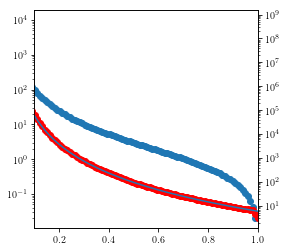

In [98]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax2=ax.twinx()

ax.set_xlim(0.1,1)
ax.set_yscale('log')
ax2.set_yscale('log')
rij=xx #[:,0]

ax.plot(rij,cikj,'o')

#ax2.plot(rij,-np.gradient(cikj,rij),'ro')
#ax2.plot(rij,-dCikj*rij,'-')

ax2.plot(rij,np.gradient(np.gradient(cikj,rij),rij),'ro')
ax2.plot(rij,ddCikj,'-')

#ax2.plot(rij,ddfcij,'o')
plt.show()

In [87]:
np.gradient(cikj,rij)

array([            nan,             nan, -4.31244000e+05, -9.09655312e+04,
       -3.44995200e+04, -1.68454687e+04, -9.50496980e+03, -5.89591406e+03,
       -3.91151020e+03, -2.72896594e+03, -1.98000000e+03, -1.48240125e+03,
       -1.13879290e+03, -8.93841199e+02, -7.14487101e+02, -5.80137317e+02,
       -4.77502007e+02, -3.97740234e+02, -3.34813561e+02, -2.84501250e+02,
       -2.43792187e+02, -2.10498750e+02, -1.83005440e+02, -1.60101563e+02,
       -1.40867605e+02, -1.24596662e+02, -1.10739200e+02, -9.88636374e+01,
       -8.86278240e+01, -7.97581378e+01, -7.20339866e+01, -6.52761914e+01,
       -5.93381894e+01, -5.40993103e+01, -4.94595918e+01, -4.53357483e+01,
       -4.16580123e+01, -3.83676420e+01, -3.54149403e+01, -3.27576705e+01,
       -3.03597816e+01, -2.81903763e+01, -2.62228714e+01, -2.44343112e+01,
       -2.28048026e+01, -2.13170487e+01, -1.99559620e+01, -1.87083419e+01,
       -1.75626053e+01, -1.65085594e+01, -1.55372113e+01, -1.46406062e+01,
       -1.38116903e+01, -

In [405]:
xlim=ax.axis()[:2]
ylim=ax.axis()[2:]

In [452]:
n=1000
lx=50
#sarr=np.c_[np.arange(1,n+1,dtype=int),np.ones(n,dtype=int)*2,np.linspace(0,lx,n),np.zeros(n),np.zeros(n)]
sarr=np.c_[np.arange(1,n+1,dtype=int),np.ones(n,dtype=int)*2,np.random.random(n)*lx,np.random.random(n)*lx,np.random.random(n)*lx]
sfile=open('data.txt','w')
for item in sarr:
    print >> sfile, int(item[0]),int(item[1]),item[2],item[3],item[4]
sfile.close()
          
           
           

## PDF

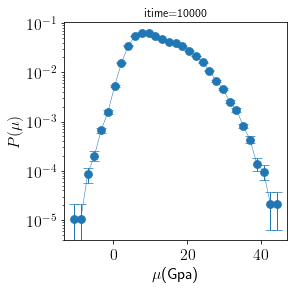

In [32]:
def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=True)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]
    
    return  hist, edges, hist / count**0.5



#--- size distribution
itime = ITIME = np.max(coord_atoms_broken.keys()) #rand.sample(coord_atoms_broken.keys(),1)[0]
value = np.c_[coord_atoms_broken[itime][muColmn]].astype(float)*1e-6
hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P(\mu)$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(r'itime=%s'%itime)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
#
plt.savefig('muPDF.png',dpi=75,bbox_inches='tight')
plt.show()

### make a fit

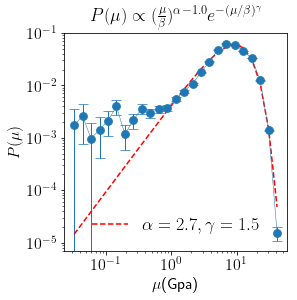

In [88]:
from scipy.optimize import curve_fit

def func(x,alpha,beta):
    return (alpha/beta)*(x/beta)**(alpha-1.0)*np.exp(-(x/beta)**alpha)

def func2(x,alpha0,alpha1,beta,c):
    return c*(x/beta)**(alpha0-1.0)*np.exp(-(x/beta)**alpha1)

value = np.c_[coord_atoms_broken[itime][muColmn]].astype(float)*1e-6
value = value[value>0]
hist, edges2, error = GetPDF( value, linscale = False, n_per_decade=8)

#--- fit
rc = 0.8
hist_filt=hist[edges2>rc]
error_filt=error[edges2>rc]
edges2_filt=edges2[edges2>rc]
popt0, pcov = curve_fit(func2, edges2_filt, hist_filt, 
#                       p0=(1.0,20.0),
                       p0=(1.0,1.0,20.0,1.0),
                       sigma=error_filt,
 #                      bounds=((1.0,0.0), (6.0,100.0))
                       )

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P(\mu)$',fontsize=16)
ax.tick_params(labelsize=16)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
ax.plot(edges2,func2(edges2,*popt0),'--r',label=r'$\alpha=%2.1f,\gamma=%2.1f$'%(popt0[0],popt0[1]))
#
xstr = r'$P(\mu)\propto(\frac{\mu}{\beta})^{\alpha-1.0} e^{-(\mu/\beta)^\gamma}$' 
ax.set_title(xstr,fontsize=18)
ax.legend(frameon=False, fontsize=18)
#
plt.savefig('muPDFfit.png',dpi=75,bbox_inches='tight')
plt.show()

### log-normal distribution

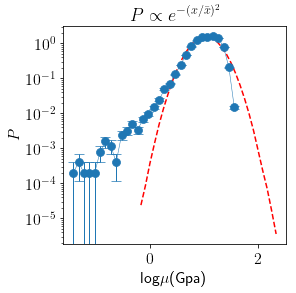

In [92]:
#--- size distribution
itime = ITIME = np.max(coord_atoms_broken.keys()) #rand.sample(coord_atoms_broken.keys(),1)[0]
#
value = np.c_[coord_atoms_broken[itime][muColmn]].astype(float)*1e-6
value = value[ value > 0.0 ]
value = np.log10( value )
hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#--- fit a gaussian
value = np.random.normal(loc=np.mean(value), scale=np.std(value), size=10000000)
hist_g, edges2_g, error_g = GetPDF( value, linscale = True, n_per_decade=32)

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'log$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P$',fontsize=16)
ax.tick_params(labelsize=16)
xstr = r'$P\propto e^{-(x/\bar{x})^2}$' 
ax.set_title(xstr,fontsize=18)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
ax.plot(edges2_g,hist_g,'--r',)
#
plt.savefig('muPDFGauss.png',dpi=75,bbox_inches='tight')
plt.show()

## Interpolation


### mapping & add copies

In [54]:
def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin ): #, **kwargs ):
############################################################
####### map atoms within a tilted box to an orthogonal one
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

    #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
    #--- [b0,b1]^{-1}*(x=|b0|,y)
    
    b2 = CellVector[:,2]
    b1 = CellVector[:,1]
    b0 = CellVector[:,0]
    norm_b0 = np.dot(b0,b0)**0.5
    shift0 = np.dot(b1, b0 / norm_b0 )
    #
    beta0 = DimensionlessCords[:,0]
    beta1 = DimensionlessCords[:,1]
    indices_shiftTrue = (beta0) + (beta1)*shift0/norm_b0 >= 1.0
    n = len( indices_shiftTrue )
    shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
    #
    xyz = coord_atoms_broken - shift_matrix
    #
    return xyz 
#
def AddCopies( coord_atoms_broken, CellVector, CellOrigin, 
               **kwargs ):    
############################################################
####### add replicals of the center simulation box
############################################################
    assert type(coord_atoms_broken) == type(pd.DataFrame())
    
    assert type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    #--- orignial cell
    XYZ_shifted = np.c_[coord_atoms_broken]
    xyz_original = XYZ_shifted.copy()
    #--- add other attributes to xyz 
    attr_list = list(coord_atoms_broken.keys()) 

#     #--- exclude xyz
    df = pd.DataFrame(kwargs)
    ID_TYPE_shifted = np.c_[df] #values[:,3:]
    id_type_original = ID_TYPE_shifted.copy()
    
    #--- cell copies
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
    #            print i,j,k
                if i == j == k == 0:
                    continue
                total_shift = np.matmul( CellVector, np.array([i,j,k]) ) #--- shape (3,)
                total_shift = np.concatenate([total_shift,total_shift, total_shift],axis=0) #--- shape: (6,)
                assert total_shift.shape[ 0 ] == 9
                #--- add shift
                xyz_shifted = xyz_original + total_shift
                #--- append
                XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
                ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
    return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list + list(df.keys()))
#
def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin): #, **kwargs  ):
############################################################
####### compute dimensionless coords of atoms given 
####### corresponding cartesian coords
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
        
    return beta 

def shiftBeta( xyzDimensionless_j, diff ):
    indices = diff > 0.5
    beta0_j = xyzDimensionless_j - 1.0 * indices

    indices = diff < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j
#
def GetXYZ( CellVector, CellOrigin, DimensionlessCords ): #, attr_list = ['x','y','z'], **kwargs ):
############################################################
####### compute coords of atoms given 
####### corresponding dimensionless coords
############################################################
    assert type(DimensionlessCords) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
        
    return XYZ 
#
def MapCoord( coord_atoms_broken,
              KEYS,
              **kwargs
            ):
############################################################
##### map coords and add images of atoms and 
##### relevant attributes
############################################################
    coord = {}
    for itime in KEYS:
        #--- map atoms in the ref. state to an undeformed box
        df = coord_atoms_broken[ itime ]
        xyz = np.c_[df[['x','y','z']].astype('float')]
        xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

        #--- append ['xm','ym','zm']
        #--- column list
        AddColumns = ['xm','ym','zm'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        
        columns = list(df.keys())+ AddColumns
        coord[itime] = pd.DataFrame(np.c_[df, xyz_mapped],columns=columns)


    return coord 
#    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict
#
def GetCopies( coord_atoms_broken,
               CellVector,
               CellOrigin,
               KEYS,
               ev = 0.1,
               columns_r = ['x','y','z'],
               columns_rm = ['xm','ym','zm'] #--- transform these coulmns
             ):
############################################################
####### add replicals of the center simulation box
############################################################
    
    columns = columns_r + columns_rm
    assert len( columns ) == 9
    for itime in KEYS:
        df = coord_atoms_broken[ itime ].copy()
        #
        xyz = np.c_[df[columns].astype('float')] #--- store 'xyz','xm'
        #--- store other columns in a dict. and pass as a kwrd arg.
        for item in columns: #--- pop 'xyz'
            df.pop( item )
        sdict = to_dict(df) #--- store in a dic. 
        #---
        xyz_copy = AddCopies( pd.DataFrame(xyz, columns=columns), CellVector[ itime ], CellOrigin[itime],
                              **sdict
                            )
        #--- print mapped xyz
#         PrintOvito( xyz_copy, 
#                     open( 'xyz_copy.xyz','w'), 
#                     footer = 'ITIME=%s'%itime,
#                     attr_list=['id','type','xm','ym','zm'] )

        #--- exclude atoms in the replicas which are out of the expanded box
        if ev == 1.0:
            indices = len(xyz_copy) * [True] #--- full copies
        else:
            indices =  isInsideExpanded( CellOrigin[ itime ], 
                                       CellVector[ itime ],
                                       np.c_[xyz_copy[columns_rm]], #--- give mapped coordinates
                                       ev = ev,
                                     )
        coord_atoms_broken[itime] = xyz_copy[ indices ]

def isInsideExpanded( CellOrigin, CellVector, xyz, ev = 0.2):
############################################################
####### Get atoms inside an expanded box
############################################################    
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

#
#--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    return isInside( CellOrigin_expanded, CellVector_expanded, 
                     xyz )


def isInside( CellOrigin, CellVector, xyz ):
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    DimensionlessCords = GetDimensionlessCords( CellVector, 
                                                xyz,
                                                CellOrigin,
                                              )
    #--- filter: only inside the expanded box 
    beta0 = DimensionlessCords[:,0]
    beta1 = DimensionlessCords[:,1]
    beta2 = DimensionlessCords[:,2]
    index0 = np.all([beta0 >= 0.0, beta0 < 1.0], axis=0 )
    index1 = np.all([beta1 >= 0.0, beta1 < 1.0], axis=0 )
    index2 = np.all([beta2 >= 0.0, beta2 < 1.0], axis=0 )
    
    return np.all([index0,index1,index2],axis=0)   



def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
    
    assert type(coord_atoms_broken_i) == type( coord_atoms_broken_j ) ==\
           type( CellVector_i ) == type( CellVector_j ) ==\
           type( CellOrigin_i ) == type( CellOrigin_j ) == type(np.array([]))

    
    #--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j - xyzDimensionless_i

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j[:,0], diff[:,0])
    beta1_j = shiftBeta( xyzDimensionless_j[:,1], diff[:,1])
    beta2_j = shiftBeta( xyzDimensionless_j[:,2], diff[:,2])

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print 'column already included!'
        return False
    return True
    
    
def GetDipl( coord,
        CellVector, CellOrigin,
        KEYS = [0],
        **kwargs
        ):

    times = KEYS 
    times.sort()
    
    time_pairs = [(0,0)]+zip(times[:-1], times[1:])
    for time_i, time_j in time_pairs:   
    #    print time_i, time_j
        #--- estimate unwrapped coordinates (deformed state)
        # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
        xyz_i = np.c_[coord[time_i][['x','y','z']]].astype('float')
        xyz_j = np.c_[coord[time_j][['x','y','z']]].astype('float')
        rj_unwrpd = EstimateUnwrappedCord( xyz_i, xyz_j,
                                           CellVector[time_i], CellVector[time_j],
                                           CellOrigin[time_i], CellOrigin[time_j] )    
        #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
        disp = rj_unwrpd - xyz_i
        #--- 
        
        #--- append (xm,ym,zm) denoting mapped coordinates
        ikey = time_j #if REF == 'initial' else time_i
        df = coord[ ikey ]
        #--- column list
        AddColumns = ['ux','uy','uz'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        #--- append
        columns = list(df.keys()) + AddColumns
        
        coord[ ikey ] = pd.DataFrame(np.c_[df, disp],columns = columns )

def GetDiplUnwrapped( coord,
        CellVector, CellOrigin,
        KEYS = [0],
        **kwargs
        ):

    times = KEYS 
    times.sort()
    
    time_pairs = [(0,0)]+zip(times[:-1], times[1:])
    for time_i, time_j in time_pairs:   
    #    print time_i, time_j
        #--- estimate unwrapped coordinates (deformed state)
        # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
        xyz_i = np.c_[coord[time_i][['xu','yu','zu']]].astype('float')
        xyz_j = np.c_[coord[time_j][['xu','yu','zu']]].astype('float')
       #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
        disp = xyz_j - xyz_i
        #--- 
        
        #--- append (xm,ym,zm) denoting mapped coordinates
        ikey = time_j #if REF == 'initial' else time_i
        df = coord[ ikey ]
        #--- column list
        AddColumns = ['ux','uy','uz'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        #--- append
        columns = list(df.keys()) + AddColumns
        
        coord[ ikey ] = pd.DataFrame(np.c_[df, disp],columns = columns )
        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def Wrap( CellOrigin, CellVector, xyz ):
############################################################
####### Wrap atom positions 
############################################################    
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    DimensionlessCords = GetDimensionlessCords( CellVector, 
                                                xyz,
                                                CellOrigin,
                                              )
    
    DimensionlessCords = DimensionlessCords % 1.0
    
    XYZ = GetXYZ( CellVector, CellOrigin, DimensionlessCords )
    
    indices = isInside( CellOrigin, CellVector, XYZ )
    
    assert len( XYZ[ indices ] ) == len( XYZ ), 'not all atoms are inside!'
    
    return XYZ



def WrapDataFrame( coord_atoms_broken, 
                   CellOrigin, CellVector,
                   KEYS,
                   columns = ['x','y','z']):
    
    for itime in KEYS:
        df = coord_atoms_broken[ itime ].copy()
        xyz = np.c_[df[columns]].astype(float)
        xyz_wrapped = Wrap(CellOrigin[ itime ], CellVector[ itime ], xyz)
        #--- replace associated columns
        for item in columns:
            df.pop( item )
        columns2 = list(df.keys())+columns
        coord_atoms_broken[ itime ] = pd.DataFrame(np.c_[df,xyz_wrapped],columns = columns2 )
        


# ITIME = 300
# JTIME = 600
#--- wrap coordintaes (don't trust lammps!)
WrapDataFrame(coord_atoms_broken, 
              CellOrigin, CellVector,
              KEYS = coord_atoms_broken.keys(), #[0,ITIME],#,
              columns = ['x','y','z']
              )

#--- print actual xyz
# PrintOvito( coord_atoms_broken[ ITIME ], 
#              open( 'xyz_actual.xyz','w'), 
#              footer = 'ITIME=%s'%ITIME,
#              attr_list=['id','type','x','y','z','ux','uy','uz'] )

#--- map to the squared cell    : add columns = ['xm','ym','zm']
coord = MapCoord( coord_atoms_broken,
                  KEYS = coord_atoms_broken.keys(),#[0,ITIME],#
                  AddColumns = ['xm','ym','zm']
                )

#--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_mapped.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )

#--- add replicas
GetCopies( coord,
           CellVector,
           CellOrigin,
           KEYS = coord.keys(), #[0,ITIME],#[ITIME]
           ev = 1.0, #--- don't change this! need a full copy to compute displ.
           columns_r = ['x','y','z','xu','yu','zu'],
           columns_rm = ['xm','ym','zm'] #--- transform these two sets of columns
         )

#--- compute displacements: x_{i+1}-x_i, add columns = ['ux','uy','uz']
GetDiplUnwrapped(    coord,
                     CellVector, CellOrigin,
                     KEYS = coord.keys(), #[0,ITIME],#,
                     AddColumns = ['ux','uy','uz']
                )        

# #--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )




In [55]:
def IntegrateColumnInTime( coord, col, colnew ): 
    
    if not isSane( [colnew], coord[ 0 ].keys() ):
        return
    
    times = coord.keys()
    times.sort()
    xsum = np.zeros( len( coord[ 0 ] ) )
    for itime in times:
        xsum += coord[ itime ][ col ]
        coord[ itime ][ colnew ] = xsum.copy()

#--- integrate U=\sum_{itime=0}u_{itime}
IntegrateColumnInTime( coord, 'ux', 'Ux' )
IntegrateColumnInTime( coord, 'uy', 'Uy' )
IntegrateColumnInTime( coord, 'uz', 'Uz' )

In [56]:
# #--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#              open( 'xyz_expanded.xyz','w'), 
#              footer = 'ITIME=%s'%ITIME,
#              attr_list=['id','type','xu','yu','zu','Ux','Uy','Uz'] )

In [57]:
# #--- assert displacements are additive

# cords = {}
# cords[ITIME] = coord[ITIME].copy()
# cords[0] = coord[0].copy()
# for ikey in ['ux','uy','uz','Ux','Uy','Uz']:
#     cords[ITIME].pop(ikey)
#     cords[0].pop(ikey)

# GetDiplUnwrapped( cords,
#          CellVector, CellOrigin,
#          KEYS = cords.keys(), #[0,ITIME],#,
#          AddColumns = ['ux','uy','uz']
#        )  
# #--- integrate U=\sum_{itime=0}u_{itime}
# IntegrateColumnInTime( cords, 'ux', 'Ux' )
# IntegrateColumnInTime( cords, 'uy', 'Uy' )
# IntegrateColumnInTime( cords, 'uz', 'Uz' )

# hist, edges = np.histogram(cords[ITIME]['Ux']-coord[ITIME]['Ux'],bins=32)
# #hist2, edges2 = np.histogram(,bins=32)
# plt.yscale('log')
# plt.plot(edges[:-1],hist,'o')
# #plt.plot(edges2[:-1],hist2,'s',color='red')
# plt.show()

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

### cubic grid

In [58]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0)
print 'dmean=%s'%dmean

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))
print xlin.shape, ylin.shape, zlin.shape

dmean=2.287993253406484
(35,) (39,) (39,)


### linear intrp: center box + margin

In [59]:
def isKeyInDataFrame(values_column, df):
    trueFalse = [key in df.keys() for key in values_column]
    return np.all(trueFalse)

def Intrp( coord,
           grid,
           CellOrigin, CellVector,
           keys = [],
           ev = 0.0,
           points_column = [],
           values_column = [],
         ):
    
    #--- linear interpolation
    df_intrp = {}
    keys.sort()
    assert keys[ 0 ] == 0, 'keys must contain itime = 0!'
    for itime in keys:
        #--- get a chunck of full copies
        df_i = coord[ 0 ]
        df_j = coord[ itime ]

        if itime == 0:
            indices =  isInsideExpanded(   CellOrigin[ itime ], 
                                           CellVector[ itime ],
                                           np.c_[df_i[points_column]], #--- give mapped coordinates
                                           ev = ev,
                                       )
        
        #--- assert columns are included in the df
        if not( isKeyInDataFrame(values_column, df_i) and isKeyInDataFrame(points_column, df_i) ):
            continue
        
        #--- interpolate
        points = df_i[indices][ points_column ]
        values = df_j[indices][ values_column ]
        xi = grid
        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'


    #     x, y, z, d = np.c_[pointsValues[['xm','ym','zm','mu']].iloc[:-1]].T
    #     rbfi = Rbf(x.tolist(), y.tolist(), z.tolist(), d.tolist(), function = 'gaussian', epsilon = dmean)  # radial basis function interpolator instance
    #     grid_z = rbfi(xv, yv, zv).flatten()   # interpolated values

        #--- store in dataframe
        df_intrp[ itime ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z']+values_column)
    return df_intrp


df_intrp = Intrp( coord,
                 xi,
                 CellOrigin, CellVector,
                 keys = coord.keys(),
                 ev = 0.3, 
                 points_column = ['xm','ym','zm'],
                 values_column = ['c_1[22]', 'ux', 'uy', 'uz', 'Ux', 'Uy', 'Uz' ],
               )



In [49]:
# df_intrp = Intrp( cords,
#                  xi,
#                  CellOrigin, CellVector,
#                  keys = cords.keys(),
#                  ev = 0.3, 
#                  points_column = ['xm','ym','zm'],
#                  values_column = ['c_1[22]', 'ux', 'uy', 'uz', 'Ux', 'Uy', 'Uz' ],
#                )

In [46]:
# #--- print mapped xyz
# PrintOvito( df_intrpp[ITIME], 
#             open( 'xyz_expanded0.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['x','y','z','Ux','Uy','Uz'] )

# PrintOvito( df_intrp[ITIME], 
#             open( 'xyz_expanded1.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['x','y','z','Ux','Uy','Uz'] )

### Strain tensor

In [61]:
def GetStrain( value, (xlin,ylin,zlin), (xv,yv,zv)):
    #--- reshape matrix
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    ux = value[:,0].reshape((ny,nx,nz))
    uy = value[:,1].reshape((ny,nx,nz))
    uz = value[:,2].reshape((ny,nx,nz))

    #--- gradient
    ux_x = np.gradient(ux,xlin,axis=1)
    ux_y = np.gradient(ux,ylin,axis=0)
    ux_z = np.gradient(ux,zlin,axis=2)

    uy_x = np.gradient(uy,xlin,axis=1)
    uy_y = np.gradient(uy,ylin,axis=0)
    uy_z = np.gradient(uy,zlin,axis=2)

    uz_x = np.gradient(uz,xlin,axis=1)
    uz_y = np.gradient(uz,ylin,axis=0)
    uz_z = np.gradient(uz,zlin,axis=2)

    #--- strain
    exx = ux_x
    exy = 0.5 * ( ux_y + uy_x )
    exz = 0.5 * ( ux_z + uz_x )

    eyx = exy
    eyy = uy_y
    eyz = 0.5 * ( uy_z + uz_y )

    ezx = exz
    ezy = eyz
    ezz = uz_z
    
    #--- subtract mean
    exx -= np.mean(exx)
    exy -= np.mean(exy)
    exz -= np.mean(exz)

    eyx -= np.mean(eyx)
    eyy -= np.mean(eyy)
    eyz -= np.mean(eyz)

    ezx -= np.mean(ezx)
    ezy -= np.mean(ezy)
    ezz -= np.mean(ezz)
    
    return np.c_[
                 exx.flatten(), eyy.flatten(), ezz.flatten(), 
                 exy.flatten(), eyz.flatten(), ezx.flatten()]


for itime in df_intrp:
    df = df_intrp[ itime ]
    #--- compute strain
    Strain = GetStrain(np.c_[df[['ux','uy','uz']]], 
                              (xlin,ylin,zlin), (xv,yv,zv))
    #--- append to data frame
    AddColumns = ['exx','eyy','ezz','exy','eyz','ezx']
    if isSane( AddColumns, df.keys() ):
        df_intrp[ itime ] = pd.DataFrame(np.c_[df,Strain], 
                                         columns = list(df.keys())+ AddColumns
                                        )
    #--- Accumulated strain
    df = df_intrp[ itime ]
    Strain = GetStrain(np.c_[df[['Ux','Uy','Uz']]], 
                              (xlin,ylin,zlin), (xv,yv,zv))
    #--- append to data frame
    AddColumns = ['Exx','Eyy','Ezz','Exy','Eyz','Ezx']
    if isSane( AddColumns, df.keys() ):
        df_intrp[ itime ] = pd.DataFrame(np.c_[df,Strain], 
                                         columns = list(df.keys())+ AddColumns
                                        )
    #--- change column name
    df_intrp[ itime ].rename(index=str, columns={"c_1[22]": "mu"}, inplace=True)


### Print

In [92]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
times = df_intrp.keys()
times.sort()
for itime in times:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1

    
    PrintOvito( df_intrp[ itime ], 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','mu', 'exy', 'Exy'] ) #'exx','eyy','ezz','exy','eyz','ezx'] )
    

### imshow

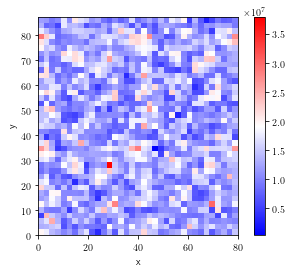

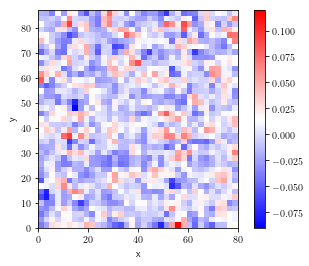

In [62]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>xlo,xv<xhi, yv>ylo,yv<yhi, zv>zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'fig.png',
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
#    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
#    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
#    plt.xlim(xlim[0]*frac,xlim[1]*frac)
#    plt.ylim(ylim[0]*frac,ylim[1]*frac)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(title,dpi=75,bbox_inches='tight')
    plt.show()


itime = ITIME
for col in ['mu', 'Exy']:

    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[df_intrp[itime][col]].reshape(((ny,nx,nz)))

    #--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                       (xlin, ylin, zlin),
#                       (xv, yv, zv ),
#                        value )

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = False,
              frac = 1.0, #--- plot a patch
              title = col,
            )

### Correlations

#### scatter plot (mu-exy)

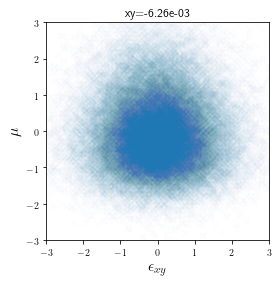

In [212]:
def zscore( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )
    return value

itime = ITIME
#
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon_{xy}$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
#
x = zscore(np.array(df_intrp[itime]['Exy'].to_list()))
y = zscore(np.array(df_intrp[itime]['mu'].to_list()))
ax.scatter(x,y,marker='x',color='C0',alpha=0.01)
#
ax.set_title('xy=%3.2e'%(np.sum(x*y)/len(x)))
#
plt.savefig('mu_exy_crltn.png',dpi=75,bbox_inches='tight')
plt.show()

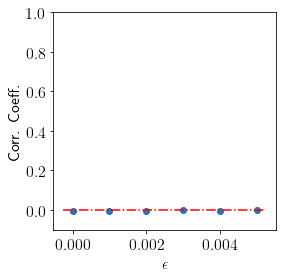

In [42]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'Corr. Coeff.',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_ylim(-0.1,1.0)
#
for itime in df_intrp:
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
    #--- strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    strain = 0.5*dx/l1                
    #
    x = zscore(np.array(df_intrp[itime]['exy'].to_list()))
    X = zscore(np.array(df_intrp[itime]['Exy'].to_list()))
    y = zscore(np.array(df_intrp[itime]['mu'].to_list()))
    crltn = np.sum(x*y)/len(x)
    crltn2 = np.sum(X*y)/len(X)
    #
    ax.plot([2*strain],[crltn], '-o',color='C0')
    ax.plot([2*strain],[crltn2], '-s',color='red')

ax.plot(ax.axis()[:2],[0,0], '-.r',color='red')

plt.savefig('crltn_strain.png',dpi=75,bbox_inches='tight')
plt.show()

In [323]:
# def GetAutoCorrelation( val ):
#     value  = val.copy()
#     value -= np.mean( value )
#     value /= np.std( value )

#     ( nx, ny, nz ) =  value.shape
#     n = nx * ny * nz
#     vq = np.fft.fftn(value) #, axes=(0,1,2))
#     vq_sq = np.abs(vq)**2

#     v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
#     return v_real


# Crltn = {}
# for itime in mu_born:
#     #
#     (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
#     #
#     value = np.c_[mu_born[itime]['mu']].reshape(((ny,nx,nz)))
#     #
#     #--- filter value
# #     value = FilterMatrix( CellVector[0], CellOrigin[0],
# #                   (xlin, ylin, zlin),
# #                   (xv, yv, zv ),
# #                    value )

#     Crltn[ itime ] = GetAutoCorrelation( value )


In [325]:
def GetAutoCorrelation2d( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny ) =  value.shape
    n = nx * ny
    vq = np.fft.fft2(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifft2( vq_sq) / n #,  axes=(0,1,2) )
    return v_real



val = value[:,:,nz/2].copy()
Crltn = GetAutoCorrelation2d( val )


(0, 17) 0.2563218405143886


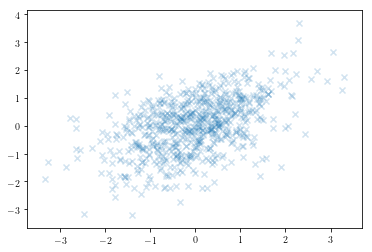

In [327]:
(m,n) = val.shape

rx=n/2
ry=0

value  = val.copy()
value -= np.mean( value )
value /= np.std( value )
    
xsum = 0.0
for i in xrange(m):
    for j in xrange(n):
        if (i+ry) >= m or (j+rx) >= n:
            continue
        xsum += value[i,j]*value[(i+ry),(j+rx)]
        plt.scatter([value[i,j].real],[value[(i+ry)%m,(j+rx)%n].real],marker='x',color='C0',alpha=0.2)
print (ry,rx), xsum / (m*n)

plt.show()

#### Print

In [307]:

# def PltCrltn( value,
#               xlabel = 'x', ylabel = 'y',
#               xlim = (-0.5,0.5), ylim = (-0.5,0.5),
#               frac = 1.0, #--- plot a patch
#               zscore = True,
#               fileName = 'cxy.png',
#               dpi=75,
#             ):
        
#     val = value.copy()
#     #--- zscore
#     if zscore:
#         val -= np.mean(val)
#         val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
#     #
#     (mgrid,ngrid) = val.shape
#     center = (ngrid/2,mgrid/2)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
#                      extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
#     plt.xlim(xlim[0]*frac,xlim[1]*frac)
#     plt.ylim(ylim[0]*frac,ylim[1]*frac)

#     plt.colorbar( pos, fraction = 0.04)
#     plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
#     plt.show()


# for itime in Crltn:
#     print 'itime=',itime
#     CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
#     #    
#     crltn = Crltn[ itime ]
#     #--- xy plane
#     val = crltn[:,:,0].copy()
#     PltCrltn( val, 
#               xlabel = 'x', ylabel = 'y',
#               xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#               frac = 1, #--- plot a patch
#               zscore = False,
#               fileName = 'cxy.%s.png'%itime,
#               dpi = 60
#             )
#     # #--- zx plane
#     # val = crltn[0,:,:].copy()
#     # PltCrltn( val, 
#     #           xlabel = 'z', ylabel = 'x',
#     #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
#     #           frac = 1.0, #--- plot a patch
#     #           zscore = False,
#     #         )
#     # #--- zy plane
#     # val = crltn[:,0,:a].copy()
#     # PltCrltn( val, 
#     #           xlabel = 'z', ylabel = 'y',
#     #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#     #           frac = 1.0, #--- plot a patch
#     #           zscore = False,
#     #         )



itime= 0


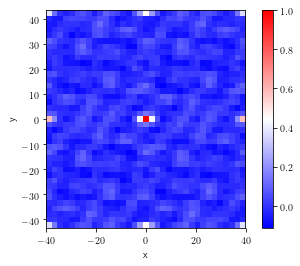

In [319]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
#    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]))
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


    
for itime in [0]:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn
    #--- xy plane
    val = crltn
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



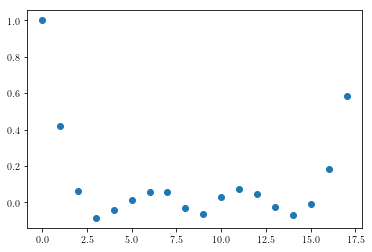

In [320]:
plt.plot(val[0,0:n/2+1],'o')
plt.show()

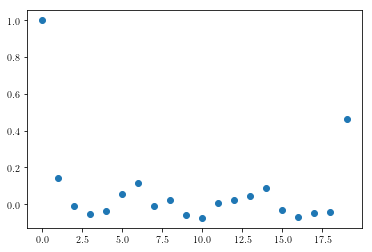

In [321]:
plt.plot(val[0:m/2+1,0],'o')
plt.show()

#### Crltn Length

In [70]:
def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot((rc,rc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)
    
    

for itime in Crltn:
    print 'itime=',itime
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1
    #---
    xc, yc = PltCrltnFunc( Crltn[ itime ], 
                 (xv,yv),
                 fileName = 'cr.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    print xc, yc

itime= [ 1.        +0.00000000e+00j  0.2658274 +6.88618955e-18j
 -0.04848971-1.71179449e-17j -0.01102252-2.93916243e-17j
 -0.00884968-1.62750514e-17j  0.00918445-2.15780525e-17j
 -0.03312712-9.97251839e-18j -0.05288246-2.03756448e-17j
  0.00139661-1.38082397e-17j  0.01228676-1.68636758e-18j
 -0.03872604+8.73879645e-18j -0.06374491+1.27488594e-17j
 -0.06287136+1.78505217e-17j -0.07180323+1.72273930e-17j
 -0.0330112 +1.26224898e-17j -0.04694569+1.20088551e-17j
 -0.0283897 +9.51409139e-18j  0.38274144-1.22170903e-17j
  0.38274144+1.63072120e-17j -0.0283897 -1.87136875e-17j
 -0.04694569-1.20088551e-17j -0.0330112 -1.24391663e-17j
 -0.07180323-1.89805432e-17j -0.06287136-2.67810349e-17j
 -0.06374491-3.35037378e-18j -0.03872604-8.73879645e-18j
  0.01228676-1.12526459e-17j  0.00139661+2.79229491e-17j
 -0.05288246+1.96805331e-17j -0.03312712+1.81927031e-17j
  0.00918445+2.15780525e-17j -0.00884968+1.95271553e-17j
 -0.01102252+2.40585852e-17j -0.04848971+2.77042212e-17j
  0.2658274 -1.24691659e

TypeError: unhashable type: 'numpy.ndarray'

In [72]:
mean = coord_atoms_broken[itime]['c_1[22]'].astype(float).mean()
std = coord_atoms_broken[itime]['c_1[22]'].astype(float).std()
'%e'%(mean-2*std)

'-5.744436e+09'